# Vorhersage des ClaimAmount/Exposure

<a id='outline'></a>

### Outline

<b>1. [Introduction](#ch1) <br><br>
2. [Importing Libraries and Datasets](#ch2) <br><br>
3. [Data Cleaning](#ch3) <br></b>
3.1. [Datasets Cleaning](#ch3-1) <br>
3.2. [Missing Values](#ch3-2)<br><br>
<b>4. [Exploratory Data Analysis and Feature Engineering](#ch4) </b><br><br>
<b>5. [Model Building](#ch5) <br></b>
5.0. [Model Setup](#ch5-0) <br>
5.1. [Claim Frequency](#ch5-1)<br>
5.2. [Claim Severity](#ch5-2)<br>
5.3. [Claim Amount/Exposure](#ch5-3)<br><br>
<b>6. [Conclusion](#ch6) <br>
</b>

<br><br>

<a id='ch1'></a>

## 1. Introduction

**Motivation**

Zwei Daten- sätze eines französischen Automobilversicherers, **freMTPL2freq** und **freMTPL2sev**, beinhalten Risikomerkmale und Schaden- informationen zu Kraftfahrt-Haftpflicht-Versicherungsverträgen. Die Aufgabe besteht in der Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr anhand der Risikomerkmale der Kunden. Dieser Wert ist Basis für die Berechnung eines fairen Versicherungsbeitrags. Die abhängige Variable ist definiert als **ClaimAmount / Exposure**.

* Explorative Datenanalyse: Machen Sie sich mit dem Datensatz vertraut. Identifizieren Sie dabei mögliche Probleme sowie grundlegende statistische Zusammenhänge, welche für die anschließende Modellierung wichtig sein könnten.
* Feature Engineering: Bereiten Sie, soweit für ihre Modellierung nötig, die Variablen geeignet auf.
* Modellvergleich: Entscheiden Sie sich für ein geeignetes Modell anhand einer dafür geeigneten Metrik. Erläutern Sie wie Sie dabei vorgehen und begründen Sie ihre Entscheidung.
* Modellbuilding: Trainieren Sie unter Berücksichtigung der vorangegangenen Schritte das von Ihnen gewählte Modell zur Vorhersage der erwarteten Schadenhöhe pro Kunde und Jahr. Ihr Ziel ist es, einen möglichst fairen Versicherungsbeitrag pro Jahr für einzelne Kunden anhand der Ihnen zu Verfügung stehenden Merkmale zu bestimmen. Wählen Sie mindestens eine geeignete Metrik, um die Güte des finalen Modells zu beurteilen. Zeigen Sie, welche Variablen und Zusammenhänge für Ihr finales Modell relevant sind. Überlegen Sie sich (ohne dies umzusetzen) wie Sie Ihr Modell weiter optimieren könnten.

<br>

**Dataset**

Die Datensätze wird von Christophe Dutang unter folgendem Link zur Verfügung gestellt.<br>
https://www.openml.org/d/41214
https://www.openml.org/d/41215

<br>

**Methodik**

* Zur Vorhersage von ClaimAmount/Exposure wird zunächst die ClaimFrequency (ClaimNb/Exposure) vorhergesagt.

* Anschließend wird anhand der vorhergesagten ClaimFrequency und der anderen unabhängigen Variablen die ClaimSeverity (ClaimAmount/ClaimNb) vorhergesagt.

* Schließlich wird die ClaimAmount/Exposure vorhergesagt, indem 
  * (1) die ClaimFrequency und die ClaimSeverity multipliziert werden und 
  * (2) ein weiteres ML-Modell unter Verwendung der vorhergesagten Merkmale und der anderen unabhängigen Variablen erstellt wird. 

  * Das beste Modell wird als endgültige Vorhersage ausgewählt.

<br>

**Roadmap**

* In **Abschnitt 2** werden wir die Bibliotheken und Datensätze importieren.
* In **Abschnitt 3** werden die Datensätze bereinigt, die Datentypen festgelegt und die fehlenden Werte behandelt.
* In **Abschnitt 4** werden die Daten ausgewertet. Ihre Beziehung zu den Zielvariablen wird veranschaulicht. Anschließend wird das Feature Engineering auf der Grundlage dieser Beziehungen durchgeführt.
* In **Abschnitt 5** werden die ML-Modelle erstellt, bewertet und verglichen. Die ausgewählten Modelle werden abgestimmt. Schließlich werden die endgültigen Vorhersagen erstellt.
* In **Abschnitt 6** wird die Studie zusammengefasst, die Ergebnisse werden bewertet und es werden Empfehlungen für die Zukunft ausgesprochen.


<br>[Return to the Outline](#outline) <br>

<br><br>

<a id='ch2'></a>

## 2. Importing Libraries and Datasets

Wir beginnen mit dem Import von Bibliotheken und Datensätzen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# Importing Datasets

import arff
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [3]:
df_freq

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
0             1.0      1.0   0.10000  'D'       5.0     0.0     55.0   
1             3.0      1.0   0.77000  'D'       5.0     0.0     55.0   
2             5.0      1.0   0.75000  'B'       6.0     2.0     52.0   
3            10.0      1.0   0.09000  'B'       7.0     0.0     46.0   
4            11.0      1.0   0.84000  'B'       7.0     0.0     46.0   
...           ...      ...       ...  ...       ...     ...      ...   
678008  6114326.0      0.0   0.00274  'E'       4.0     0.0     54.0   
678009  6114327.0      0.0   0.00274  'E'       4.0     0.0     41.0   
678010  6114328.0      0.0   0.00274  'D'       6.0     2.0     45.0   
678011  6114329.0      0.0   0.00274  'B'       4.0     0.0     60.0   
678012  6114330.0      0.0   0.00274  'B'       7.0     6.0     29.0   

        BonusMalus VehBrand   VehGas  Density Region  
0             50.0    'B12'  Regular   1217.0  'R82'  
1             50.0    'B12'  Regular   1217.0  'R82'  
2             50.0    'B12'   Diesel     54.0  'R22'  
3             50.0    'B12'   Diesel     76.0  'R72'  
4             50.0    'B12'   Diesel     76.0  'R72'  
...            ...      ...      ...      ...    ...  
678008        50.0    'B12'  Regular   3317.0  'R93'  
678009        95.0    'B12'  Regular   9850.0  'R11'  
678010        50.0    'B12'   Diesel   1323.0  'R82'  
678011        50.0    'B12'  Regular     95.0  'R26'  
678012        54.0    'B12'   Diesel     65.0  'R72'  

[678013 rows x 12 columns]

In [4]:
df_sev

IDpol  ClaimAmount
0         1552.0       995.20
1      1010996.0      1128.12
2      4024277.0      1851.11
3      4007252.0      1204.00
4      4046424.0      1204.00
...          ...          ...
26634  3254353.0      1200.00
26635  3254353.0      1800.00
26636  3254353.0      1000.00
26637  2222064.0       767.55
26638  2254065.0      1500.00

[26639 rows x 2 columns]

<br>[Return to the Outline](#outline) <br>

<br><br><br>

<a id='ch3'></a>

## 3. Data Cleaning

In diesem Abschnitt, werden 
* die Datensätze bereinigt, 
* die Datentypen festgelegt und 
* die fehlenden Werte behandelt.

<a id='ch3-1'></a>

### 3.1. Datasets Cleaning

In [5]:
# Checking dataset
df_freq.head()

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0      1.0      0.10  'D'       5.0     0.0     55.0        50.0   
1    3.0      1.0      0.77  'D'       5.0     0.0     55.0        50.0   
2    5.0      1.0      0.75  'B'       6.0     2.0     52.0        50.0   
3   10.0      1.0      0.09  'B'       7.0     0.0     46.0        50.0   
4   11.0      1.0      0.84  'B'       7.0     0.0     46.0        50.0   

  VehBrand   VehGas  Density Region  
0    'B12'  Regular   1217.0  'R82'  
1    'B12'  Regular   1217.0  'R82'  
2    'B12'   Diesel     54.0  'R22'  
3    'B12'   Diesel     76.0  'R72'  
4    'B12'   Diesel     76.0  'R72'

In [6]:
# Checking data types
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB


<br><br>

---

**Feature Descriptions**
* **IDpol:** ID des Vertrags
* **ClaimNb:** Anzahl Schäden im Versicherungszeitraum
* **Exposure:** Länge des Versicherungszeitraums (in Jahren) [Komponente der abhängigen Variable]
* **Area:** Area-Code des Versicherungsnehmers [unabhängige Variable]
* **VehPower:** Leistung des versicherten Kfz [unabhängige Variable]
* **VehAge:** Alter des versicherten Kfz [unabhängige Variable]
* **DrivAge:** Alter des Versicherungsnehmers [unabhängige Variable]
* **BonusMalus:** Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse) [unabhängige Variable]
* **VehBrand:** Marke des versicherten Kfz [unabhängige Variable]
* **VehGas:** Antrieb des versicherten Kfz [unabhängige Variable]
* **Density:** Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers [unabhängige
Variable]
* **Region:** Region des Versicherungsnehmers [unabhängige Variable]

---

<br><br>

<div class="alert alert-info">
  <strong>Erste Bemerkungen</strong>
</div>


* **IDpol** sollte eindeutig sein und kann als Index gesetzt werden.
* **ClaimNb** sollte eine integer sein. Sie sollte gleich der Anzahl der Ansprüche im **df_sev**-Datensatz sein.
* **Area**, **Density** und **Region** können die gleichen Informationen darstellen.
* Die **ClaimFrequency**, **ClaimSeverity** und **ClaimAmountPerExpose** können nützlich sein.


<br><br>

---

**IDpol** sollte eindeutig sein und kann als Index gesetzt werden.

In [7]:
# Checking if ID is unique
df_freq['IDpol'].is_unique

True

In [8]:
# Changing the ID type as int
df_freq['IDpol'] = df_freq['IDpol'].astype('int64')

# Set ID as index
df_freq = df_freq.set_index('IDpol')

<br><br>

---

**ClaimNb** sollte eine integer sein. Sie sollte gleich der Anzahl der Ansprüche im **df_sev**-Datensatz sein.

In [9]:
# Checking unique ClaimNb to be sure that they are int
df_freq['ClaimNb'].unique()

array([ 1.,  2.,  4.,  3., 11.,  0.,  5.,  6.,  8., 16.,  9.])

In [10]:
# Setting ClaimNb as int
df_freq['ClaimNb'] = df_freq['ClaimNb'].astype('int64')

In [11]:
# Adding a column to count claims for later
df_sev['ClaimCount'] = 1

In [12]:
# Changing the ID type as int
df_sev['IDpol'] = df_sev['IDpol'].astype('int64')

In [13]:
# Group claims by ID
df_sev = df_sev.groupby('IDpol').sum()

In [14]:
# Left join df_freq with df_sev
df = df_freq.join(df_sev)

In [15]:
df.head()

ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
1            1      0.10  'D'       5.0     0.0     55.0        50.0    'B12'   
3            1      0.77  'D'       5.0     0.0     55.0        50.0    'B12'   
5            1      0.75  'B'       6.0     2.0     52.0        50.0    'B12'   
10           1      0.09  'B'       7.0     0.0     46.0        50.0    'B12'   
11           1      0.84  'B'       7.0     0.0     46.0        50.0    'B12'   

        VehGas  Density Region  ClaimAmount  ClaimCount  
IDpol                                                    
1      Regular   1217.0  'R82'          NaN         NaN  
3      Regular   1217.0  'R82'          NaN         NaN  
5       Diesel     54.0  'R22'          NaN         NaN  
10      Diesel     76.0  'R72'          NaN         NaN  
11      Diesel     76.0  'R72'          NaN         NaN

<br><br>

In [16]:
# Checking the IDs that are present in df_sev but not in df_freq
[x for x in df_sev.index if x not in df.index]

[2220367, 2227533, 2262511, 2277846, 2282134, 2286775]

<br>
<div class="alert alert-warning">
Es gibt <b>6 IDs</b>, die Anspruchsdatensätze haben, aber nicht in df_freq vorkommen. Da wir keine weiteren Informationen über sie haben, können wir sie einfach ignorieren. </div>

<br><br>

In [17]:
# Filling null values with 0
df[['ClaimAmount','ClaimCount']] = df[['ClaimAmount','ClaimCount']].fillna(0)

In [18]:
# IDs having different number of claim records
df[(df['ClaimNb'] != df['ClaimCount'])]

ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
IDpol                                                                    
1              1      0.10  'D'       5.0     0.0     55.0        50.0   
3              1      0.77  'D'       5.0     0.0     55.0        50.0   
5              1      0.75  'B'       6.0     2.0     52.0        50.0   
10             1      0.09  'B'       7.0     0.0     46.0        50.0   
11             1      0.84  'B'       7.0     0.0     46.0        50.0   
...          ...       ...  ...       ...     ...      ...         ...   
4126524        1      1.00  'D'       5.0     6.0     43.0        54.0   
4136585        1      1.00  'C'       6.0    12.0     44.0        50.0   
4158255        2      0.82  'D'       8.0     1.0     22.0        95.0   
4186466        1      0.59  'D'      10.0    10.0     63.0        50.0   
5068217        1      0.95  'B'       8.0    10.0     23.0        80.0   

        VehBrand   VehGas  Density Region  ClaimAmount  ClaimCount  
IDpol                                                               
1          'B12'  Regular   1217.0  'R82'         0.00         0.0  
3          'B12'  Regular   1217.0  'R82'         0.00         0.0  
5          'B12'   Diesel     54.0  'R22'         0.00         0.0  
10         'B12'   Diesel     76.0  'R72'         0.00         0.0  
11         'B12'   Diesel     76.0  'R72'         0.00         0.0  
...          ...      ...      ...    ...          ...         ...  
4126524     'B2'  Regular   1282.0  'R31'         0.00         0.0  
4136585     'B1'   Diesel    304.0  'R11'         0.00         0.0  
4158255     'B2'  Regular   1329.0  'R11'       543.33         1.0  
4186466    'B13'  Regular   1313.0  'R24'         0.00         0.0  
5068217    'B12'  Regular     87.0  'R21'         0.00         0.0  

[9117 rows x 13 columns]

<br>
<div class="alert alert-warning">
Es gibt <b>9117 IDs</b>, deren Anspruchsdatensätze nicht übereinstimmen, die verworfen werden sollten, weil diese Informationen falsch sein oder fehlen könnten. Dies kann zu einer schlechten Modellierung führen. 
</div>

<br><br>

In [19]:
# Discarding IDs having wrong or missing claim records
df = df[~(df['ClaimNb'] != df['ClaimCount'])]

In [20]:
# Removing extra ClaimCount column
df = df.drop(columns= 'ClaimCount')

<br><br>

---

**Area**, **Density** und **Region** können die gleichen Informationen darstellen.

In [21]:
# First cleaning ' signs
df['Area'] = df['Area'].apply(lambda x: x.strip("'"))
df['VehBrand'] = df['VehBrand'].apply(lambda x: x.strip("'"))
df['Region'] = df['Region'].apply(lambda x: x.strip("'"))

In [22]:
df['Area'].unique()

array(['F', 'B', 'E', 'A', 'D', 'C'], dtype=object)

In [23]:
df['Region'].unique()

array(['R11', 'R25', 'R73', 'R93', 'R31', 'R21', 'R91', 'R22', 'R72',
       'R52', 'R26', 'R82', 'R41', 'R94', 'R24', 'R83', 'R54', 'R23',
       'R53', 'R74', 'R42', 'R43'], dtype=object)

In [24]:
# Checking if a region has different area values
df[df['Region'] == 'R11']['Area'].unique()

array(['F', 'E', 'D', 'B', 'A', 'C'], dtype=object)

In [25]:
# Checking if a region has different densities 
df[df['Region'] == 'R11'].describe()['Density']

count    68470.000000
mean      8084.430422
std       9104.656099
min         13.000000
25%       1329.000000
50%       4487.000000
75%      10155.000000
max      27000.000000
Name: Density, dtype: float64

In [26]:
# Checking if an area has different densities 
df[df['Area'] == 'A'].describe()['Density']

count    102363.000000
mean         27.511542
std          12.494998
min           1.000000
25%          16.000000
50%          27.000000
75%          38.000000
max          50.000000
Name: Density, dtype: float64

<br>
<div class="alert alert-warning">
    <b>Schlussfolgerung:</b> Area, Density und Region können für eindeutige IDs unterschiedlich sein.
    </div>

<br><br>

---

Die **ClaimFrequency**, **ClaimSeverity** und **ClaimAmountPerExpose** können nützlich sein.

In [27]:
df['ClaimSeverity'] = df['ClaimAmount'] / df['ClaimNb']
df['ClaimFrequency'] = df['ClaimNb'] / df['Exposure']
df['ClaimAmountPerExp'] = df['ClaimAmount'] / df['Exposure']

In [28]:
df.head()

ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139          1      0.75    F       7.0     1.0     61.0        50.0      B12   
190          1      0.14    B      12.0     5.0     50.0        60.0      B12   
414          1      0.14    E       4.0     0.0     36.0        85.0      B12   
424          2      0.62    F      10.0     0.0     51.0       100.0      B12   
463          1      0.31    A       5.0     0.0     45.0        50.0      B12   

        VehGas  Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
IDpol                                                                        
139    Regular  27000.0    R11       303.00         303.00        1.333333   
190     Diesel     56.0    R25      1981.84        1981.84        7.142857   
414    Regular   4792.0    R11      1456.55        1456.55        7.142857   
424    Regular  27000.0    R11     10834.00        5417.00        3.225806   
463    Regular     12.0    R73      3986.67        3986.67        3.225806   

       ClaimAmountPerExp  
IDpol                     
139           404.000000  
190         14156.000000  
414         10403.928571  
424         17474.193548  
463         12860.225806

<br><br>

<br>[Return to the Outline](#outline) <br>

<br><br>

<a id='ch3-2'></a>

### 3.2. Missing Values

In [29]:
# Checking missing values
df.isnull().sum()

ClaimNb                   0
Exposure                  0
Area                      0
VehPower                  0
VehAge                    0
DrivAge                   0
BonusMalus                0
VehBrand                  0
VehGas                    0
Density                   0
Region                    0
ClaimAmount               0
ClaimSeverity        643953
ClaimFrequency            0
ClaimAmountPerExp         0
dtype: int64

<br>
<div class="alert alert-warning">
    Einige Werte für die ClaimSeverity sind Null, weil wir diese Zahl durch Division des ClaimAmount durch die ClaimNb ermitteln, und wenn die ClaimNb 0 ist, ergibt sich Null, um den 0-Divisionsfehler zu behandeln. Wir können diese Nullwerte mit 0 füllen.
    </div>

In [30]:
# Filling missing values with 0
df = df.fillna(0)

<br><br>

<br>[Return to the Outline](#outline) <br>

<br><br>

<a id='ch4'></a>

## 4. Exploratory Data Analysis and Feature Engineering

In diesem Abschnitt, werden 
* die Daten ausgewertet. 
* Ihre Beziehung zu den Zielvariablen wird veranschaulicht. 
* Anschließend wird das Feature Engineering auf der Grundlage dieser Beziehungen durchgeführt.

In [31]:
df.describe().T

count         mean           std        min    25%  \
ClaimNb            668896.0     0.039532      0.208519   0.000000   0.00   
Exposure           668896.0     0.529071      0.364249   0.002732   0.18   
VehPower           668896.0     6.456944      2.052244   4.000000   5.00   
VehAge             668896.0     7.084611      5.663180   0.000000   2.00   
DrivAge            668896.0    45.447881     14.119447  18.000000  34.00   
BonusMalus         668896.0    59.784315     15.641455  50.000000  50.00   
Density            668896.0  1790.706019   3949.355208   1.000000  92.00   
ClaimAmount        668896.0    89.563509   5861.990605   0.000000   0.00   
ClaimSeverity      668896.0    82.837276   5614.432410   0.000000   0.00   
ClaimFrequency     668896.0     0.120240      2.038251   0.000000   0.00   
ClaimAmountPerExp  668896.0   388.483589  37070.759515   0.000000   0.00   

                      50%      75%          max  
ClaimNb              0.00     0.00        16.00  
Exposure             0.49     0.99         2.01  
VehPower             6.00     7.00        15.00  
VehAge               6.00    11.00       100.00  
DrivAge             44.00    55.00       100.00  
BonusMalus          50.00    65.00       230.00  
Density            393.00  1658.00     27000.00  
ClaimAmount          0.00     0.00   4075400.56  
ClaimSeverity        0.00     0.00   4075400.56  
ClaimFrequency       0.00     0.00       365.00  
ClaimAmountPerExp    0.00     0.00  18524548.00

<br>
<div class="alert alert-warning">
In den meisten Zeilen sind keine Anträge verzeichnet. Einige haben extreme Werte.
</div>

<br>

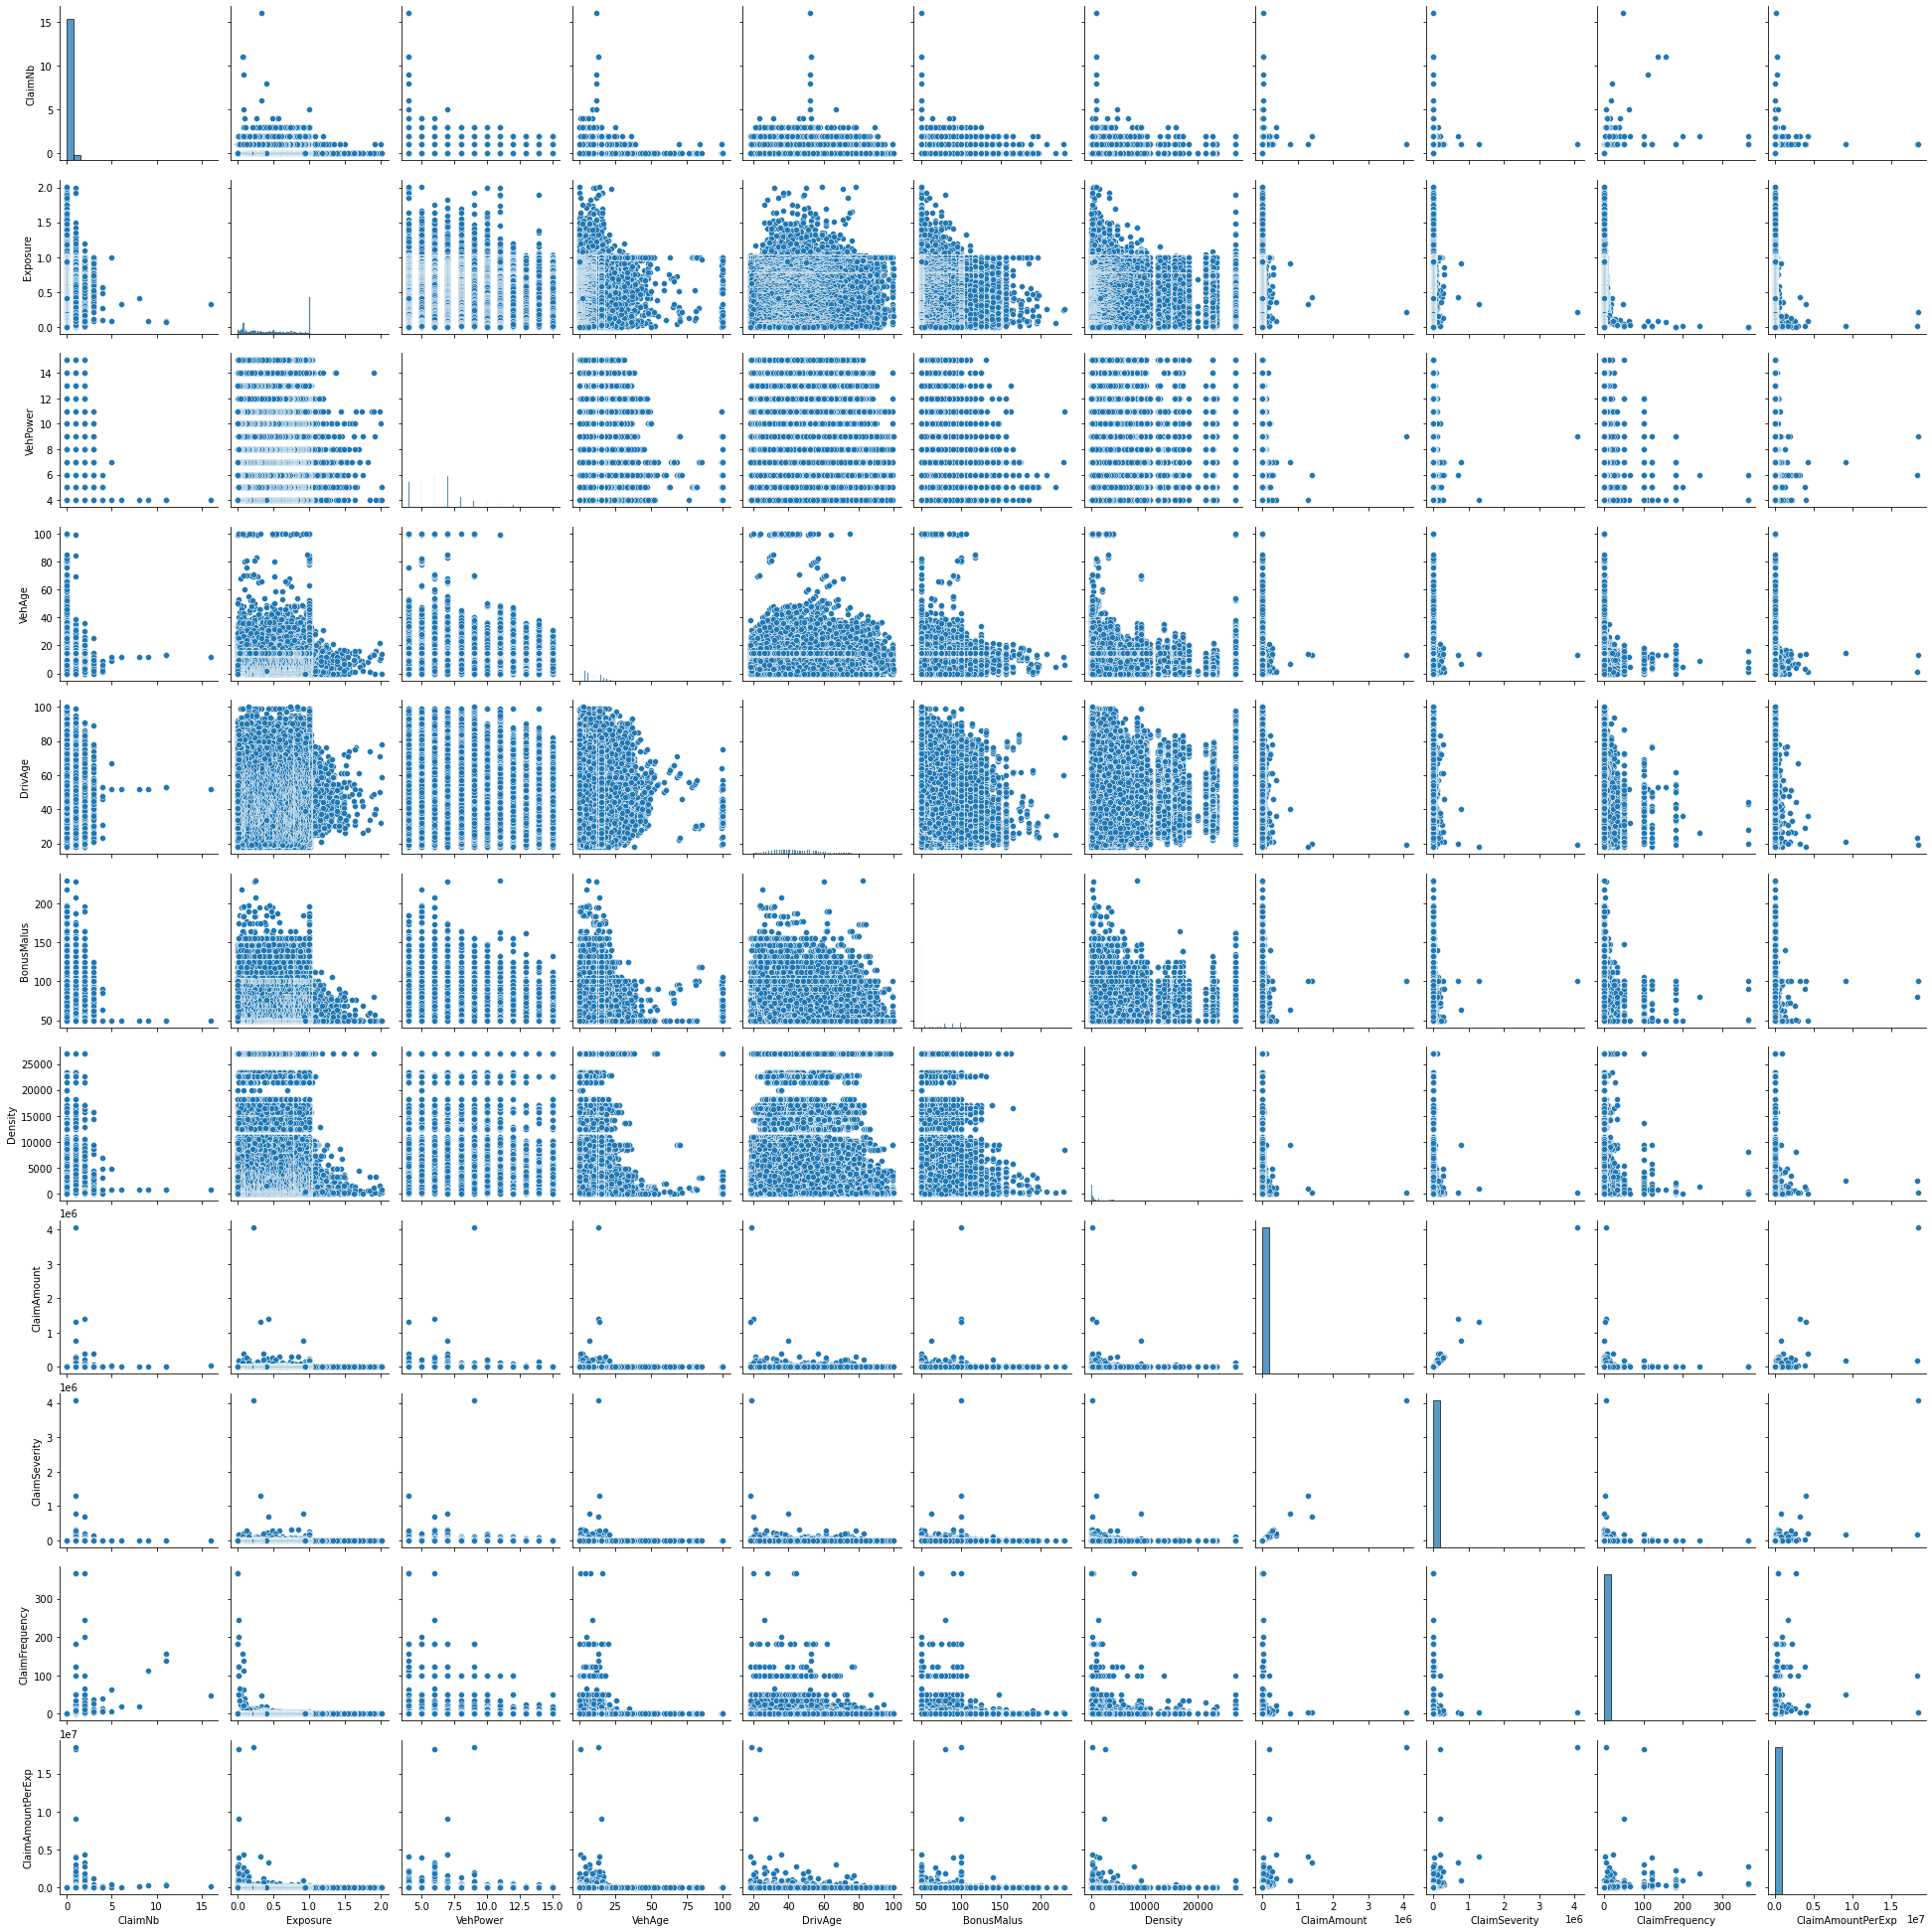

In [32]:
sns.pairplot(df)

<AxesSubplot:>

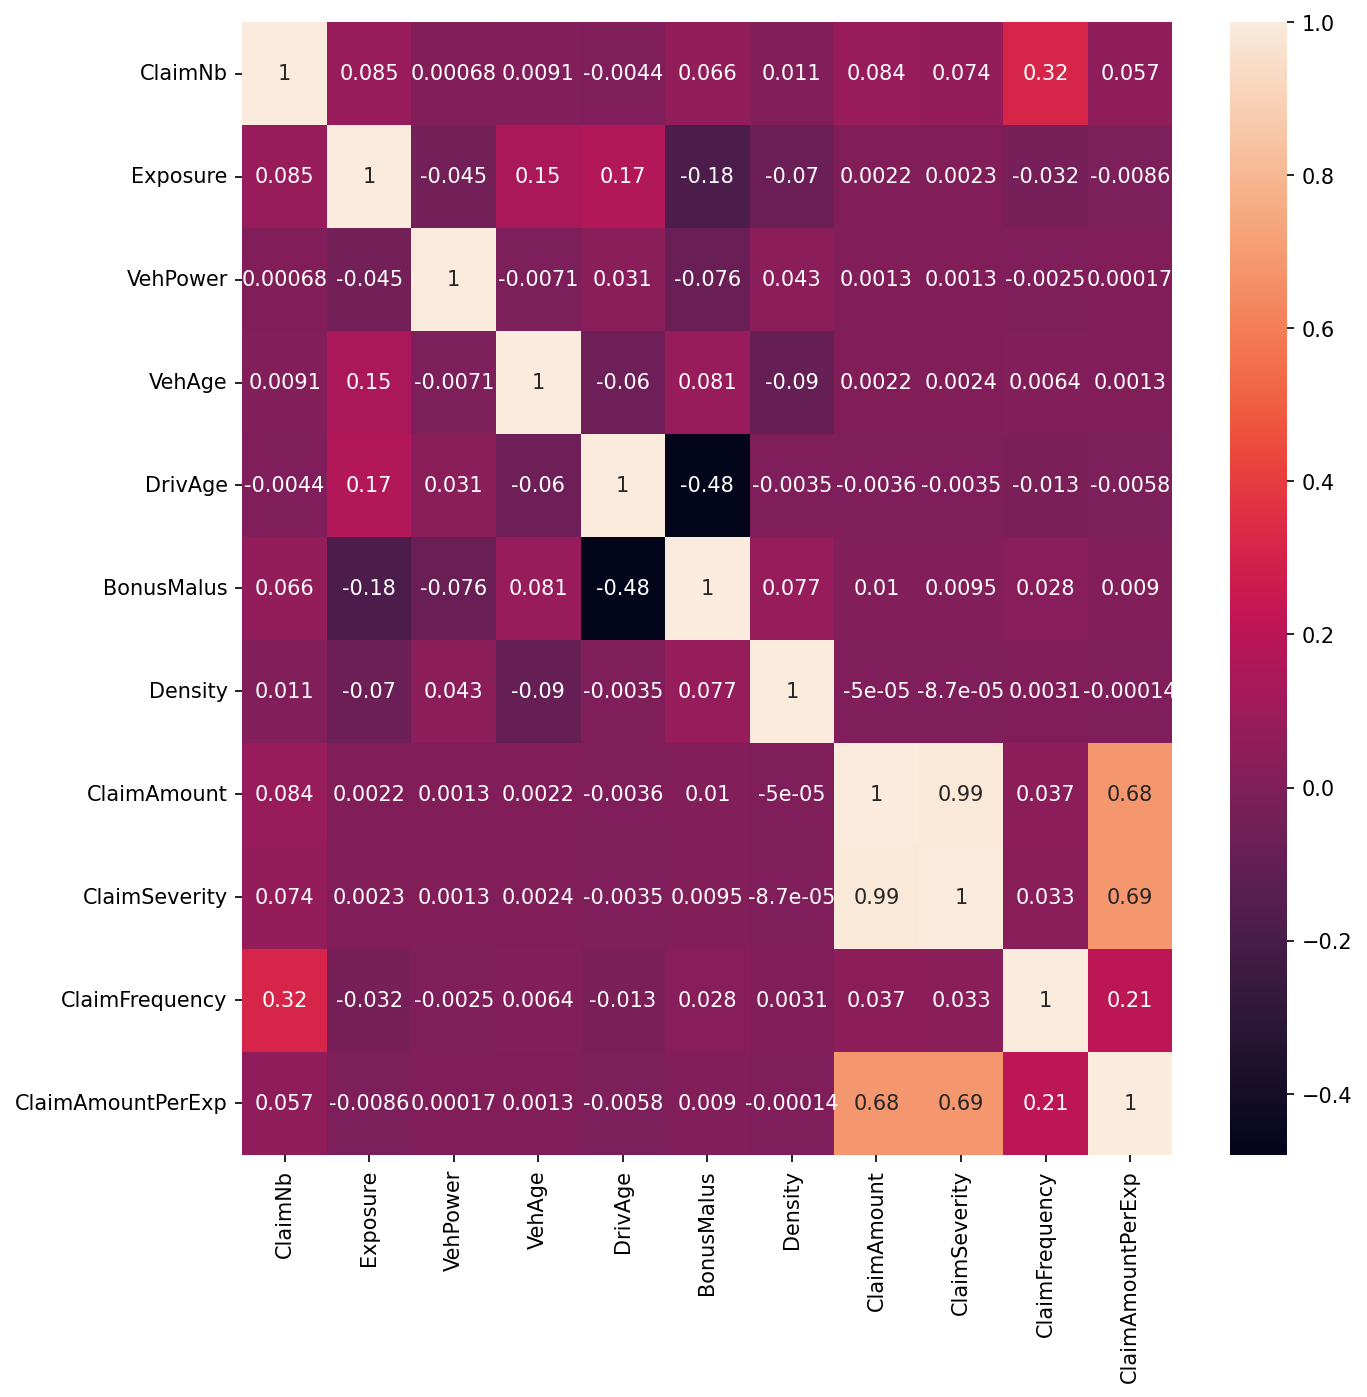

In [33]:
# Plotting correlation matrix
plt.figure(dpi = 150, figsize = (10,10))
sns.heatmap(df.corr(), annot= True)

<br>
<div class="alert alert-warning">
Die Korrelationsmatrix bestätigt, dass die Korrelation zwischen den Variablen schwach ist. Es wird von Vorteil sein, die Beziehungen zu den Zielvariablen zu überprüfen.
</div>

<br><br>

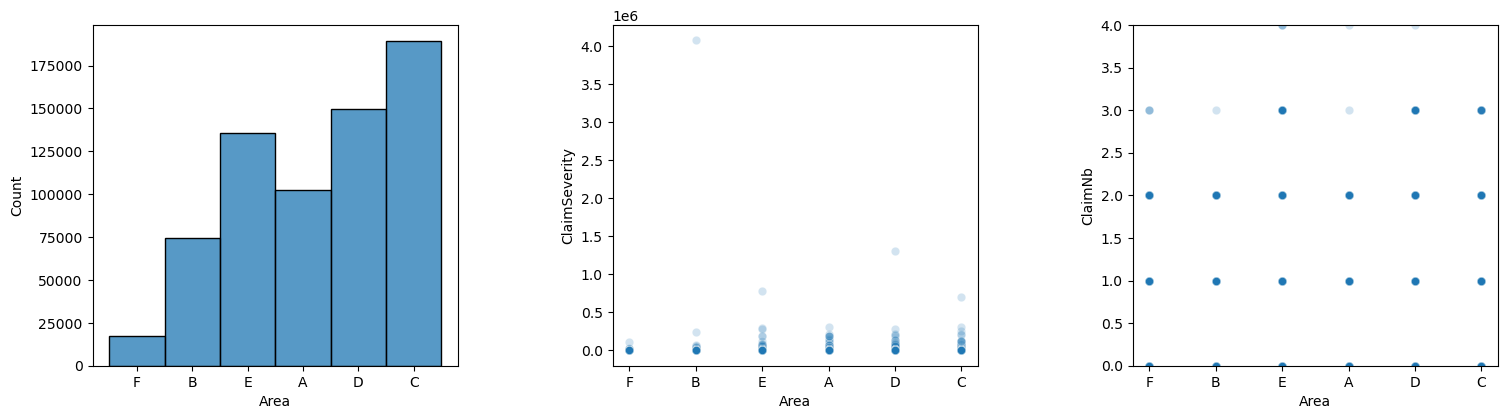

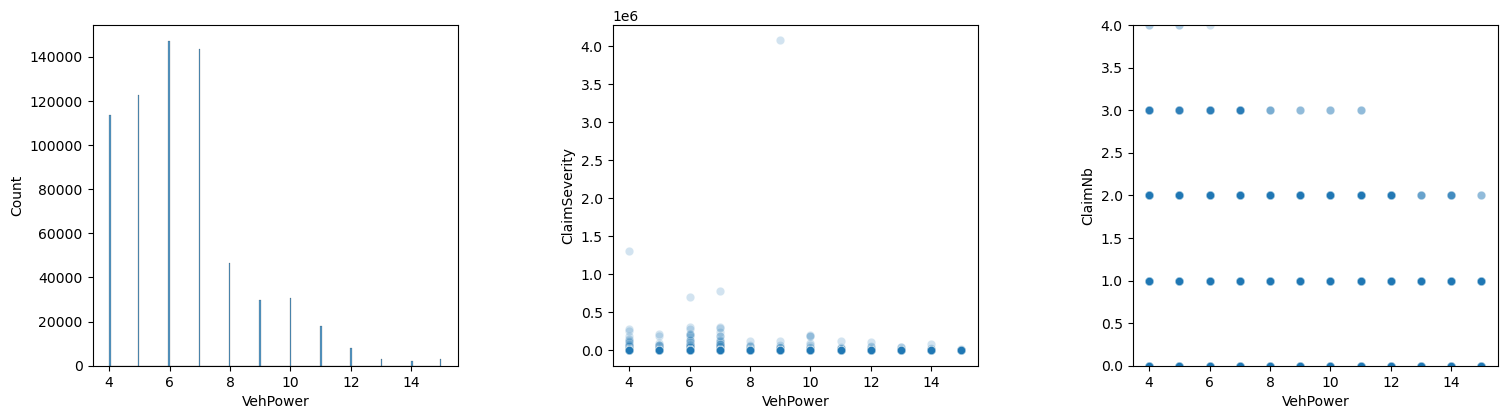

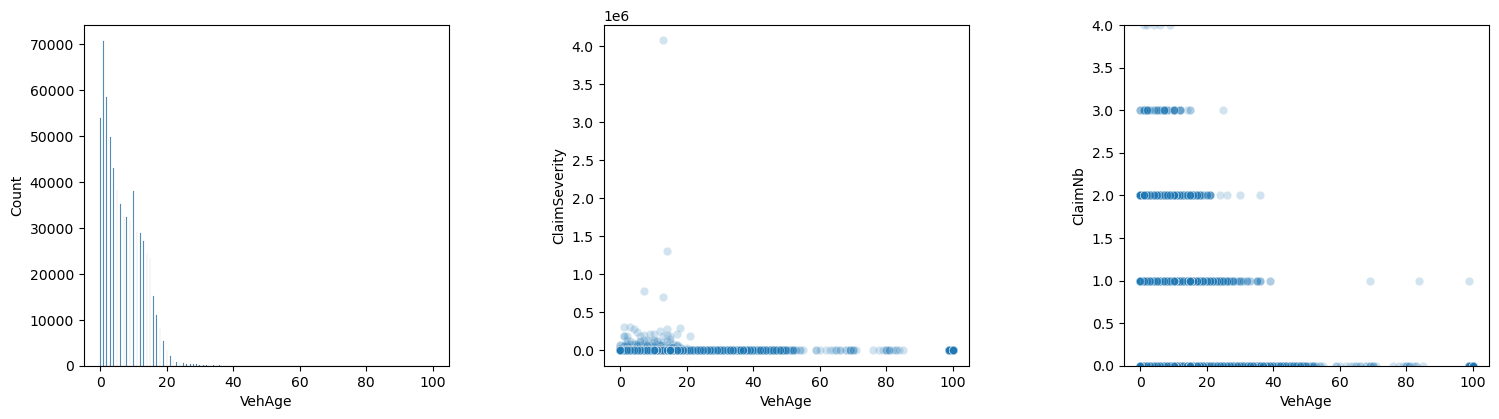

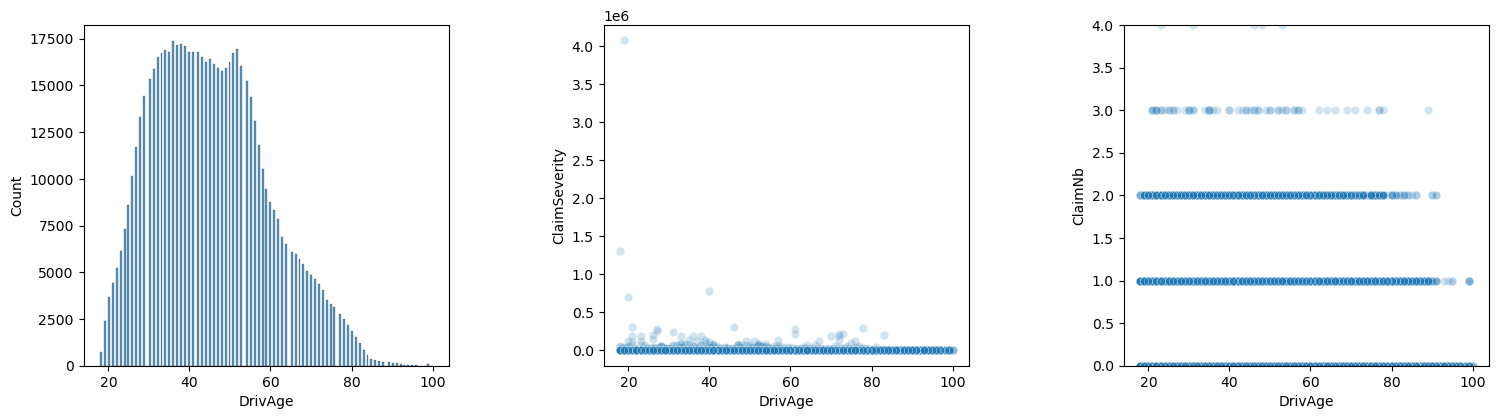

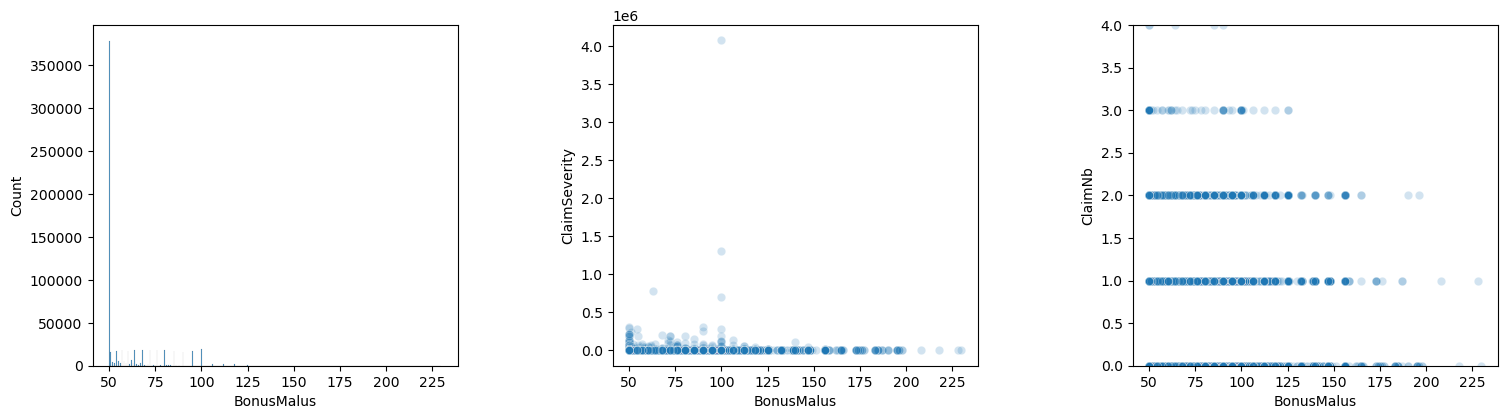

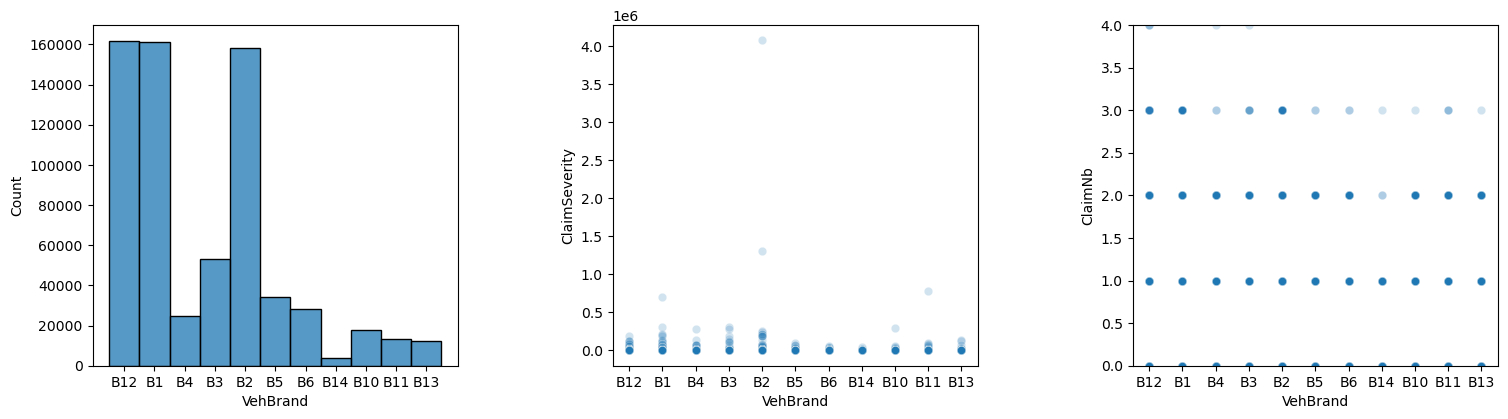

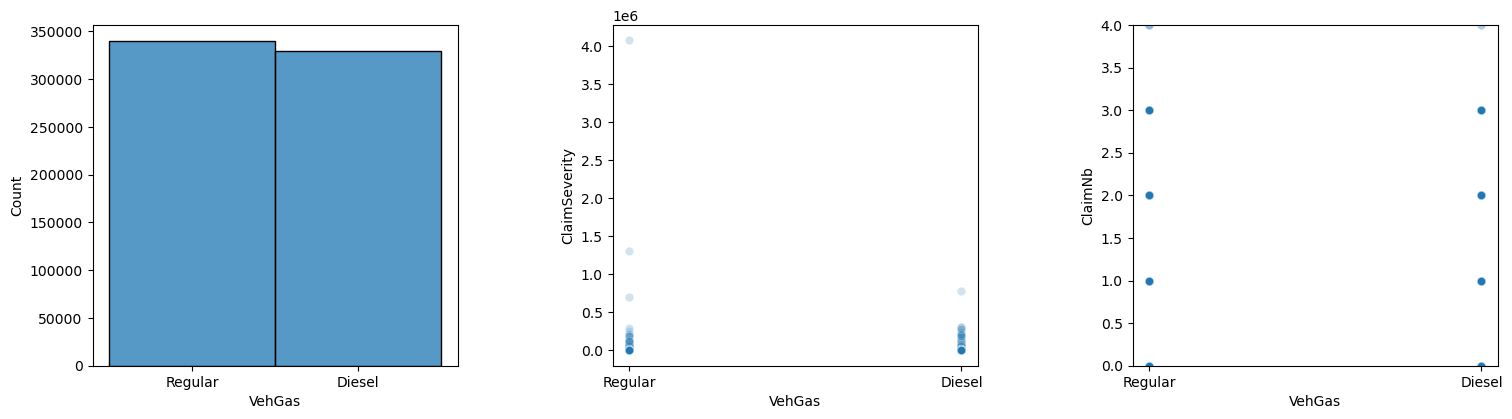

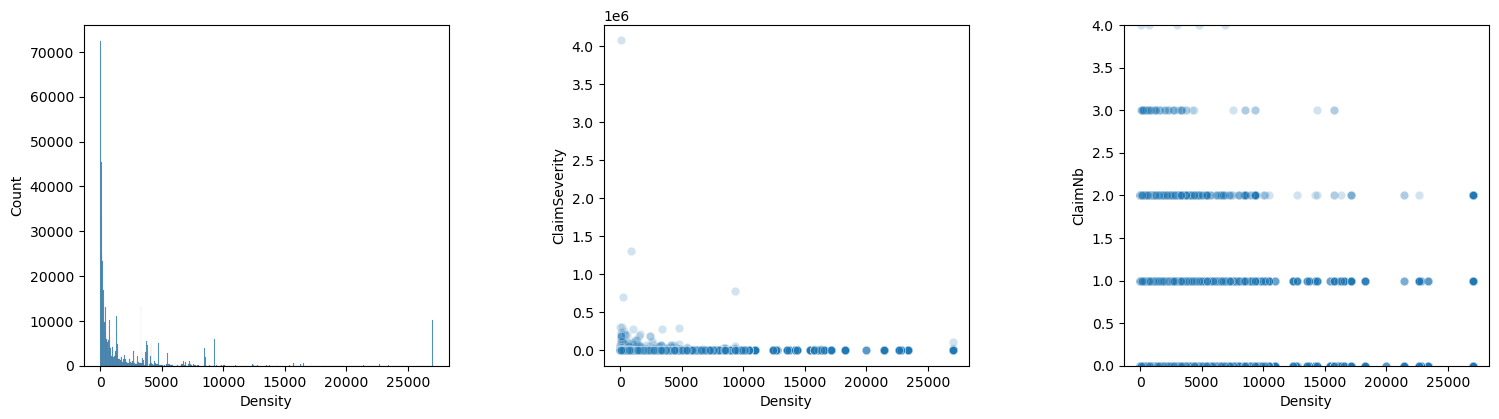

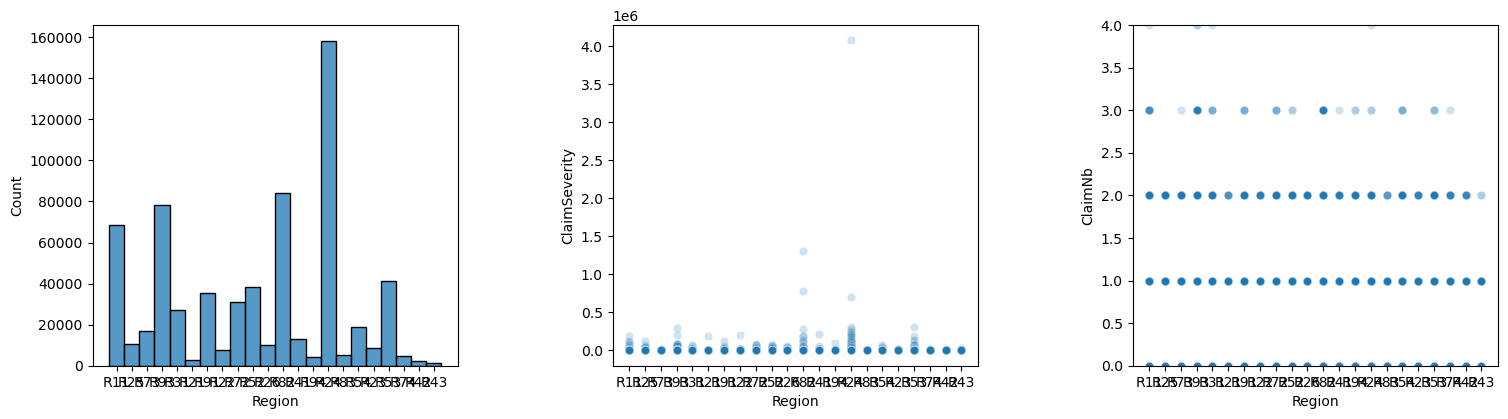

In [34]:
# Plotting independent variables vs dependent variables

for col in ['Area', 'VehPower', 'VehAge', 'DrivAge',
            'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    
    fig,ax = plt.subplots(1,3, dpi=100)
    fig.tight_layout()
    fig.set_figwidth(16)
    
    sns.histplot(df[col], ax = ax[0])
    
    
    
    sns.scatterplot(data = df, x = col, y = 'ClaimSeverity', alpha = 0.2, ax = ax[1])
    
    sns.scatterplot(data = df, x = col, y = 'ClaimNb', alpha = 0.2, ax = ax[2])
    plt.ylim(0,4)
    
    plt.show()

<br>
<div class="alert alert-warning">
Es gibt einige Unterschiede bei einigen Werten. Dies ist ein Zeichen dafür, dass <b>baumbasierte Algorithmen</b> genauere Ergebnisse liefern können. Auch <b>Poisson- und Gamma-Verteilungen</b> sind ein Hinweis darauf, dass <b>GLM-Algorithmen</b> gute Ergebnisse liefern können.
</div>

<br><br><br>

**Distribution of float values**

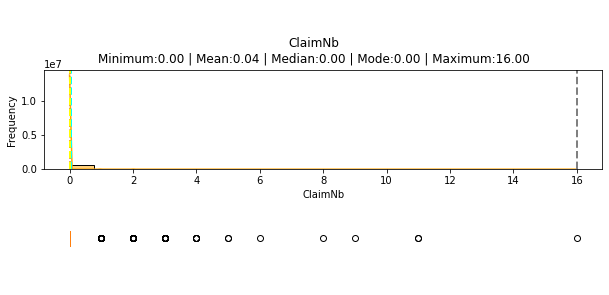

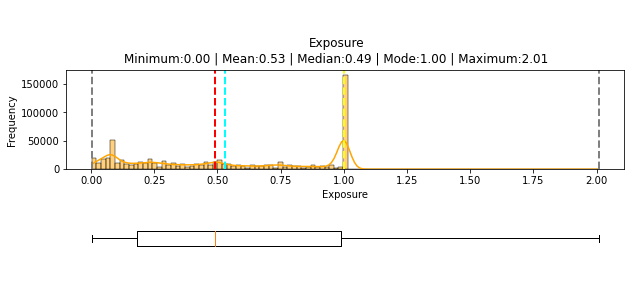

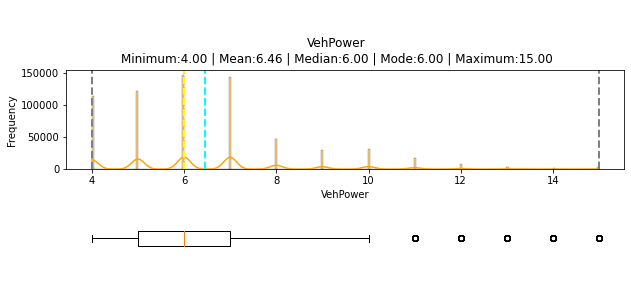

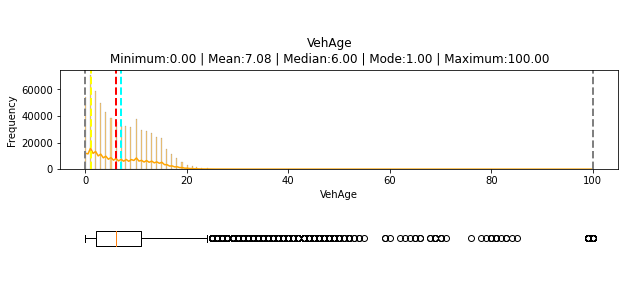

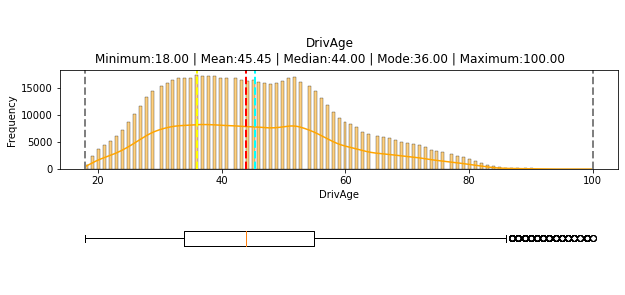

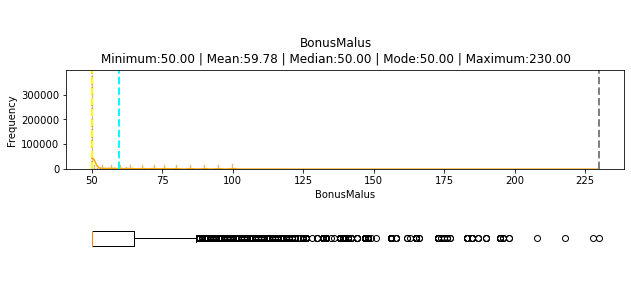

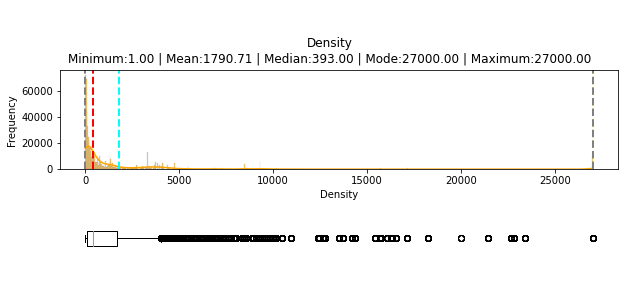

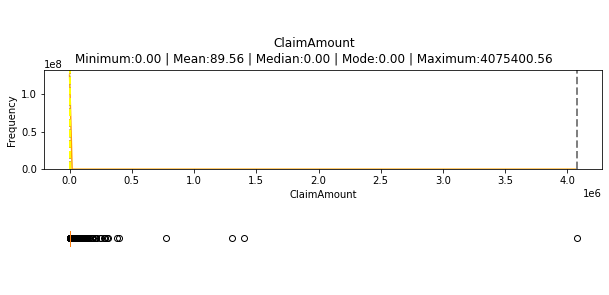

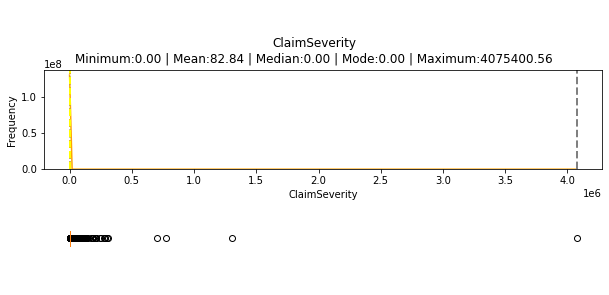

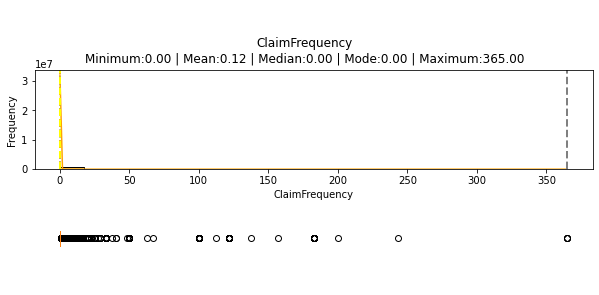

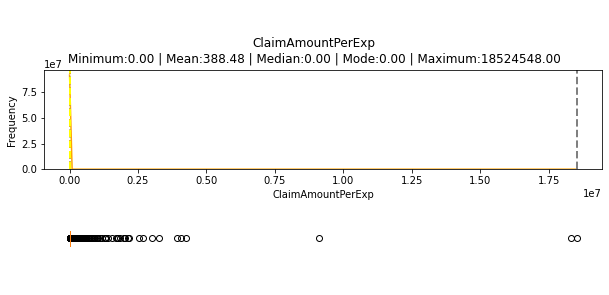

In [35]:
# Plotting distribution of float values.

for col in df.select_dtypes(['int64','float64']).columns:
    # Selecting column excluding 0 values
    var_data = df[col]

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    sns.histplot(var_data, ax = ax[0], kde = True, color = 'orange')
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')
    ax[1].axis('off')

    # Add a title to the Figure
    fig.suptitle('\n\n{}\nMinimum:{:.2f} | Mean:{:.2f} | Median:{:.2f} | Mode:{:.2f} | Maximum:{:.2f}\n'.format(col,
                                                                                            min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val), y = 1.1)
    # Show the figure
    fig.show()


---

<br><br>

<div class="alert alert-info">
  <strong>Bewertung der numerischen Merkmale</strong>
</div>

* Es gibt nur wenige Zeilen mit **Exposure** größer als eins. Dies kann ein Datenfehler sein. Ein Exposure von weniger als 0,1 bedeutet, dass es sich um recht neue Policen handelt und dass die Schadeneinträge möglicherweise betrügerisch sind oder die Zukunft nicht korrekt darstellen.
* Dieser Datensatz deckt hauptsächlich einjähriges Risiko ab. Daher entfernen wir **ClaimNb** größer als 4, da dies eine unwahrscheinliche Situation oder möglicherweise Betrug ist.
* Die **ClaimSeverity** von mehr als 100 000 ist eine unwahrscheinliche Situation und diese extremen Werte können zu einer schlechten Modellierung führen. 
* Wenn wir die Beziehung zwischen dem Zielwert und **VehPower** untersuchen. Dieses Merkmal sollte als Kategorie behandelt werden. Der Bereich der Ausreißer dieser Merkmale wird auf der Grundlage ihrer Beziehung zu den Zielwerten bestimmt. 
* Obergrenzen können auf **VehAge**, **DrivAge** und **BonusMalus** angewendet werden.
* **Density** ist nicht normalverteilt. Sie kann logarithmisch skaliert werden.


<br><br>

---

<br>

In [36]:
# Removing rows having Exposure > 1
df = df[(df['Exposure'] <= 1) & (df['Exposure'] > 0.1)]

# Removing rows having ClaimNb > 4
df = df[df['ClaimNb'] <= 4]

# Removing rows having ClaimSeverity > 100 000
df = df[df['ClaimSeverity'] <= 100000]

# Density log-scaling
df['Density'] = np.log(df['Density'])

# Upper Limiting with 1.5 IQR technique
for col in ['BonusMalus', 'VehAge', 'DrivAge']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    upper_range = Q3 + 1.5 * IQR

    df[col] = df[col].apply(lambda x: upper_range if x > upper_range else x)

df = df[df['ClaimFrequency'] <= 10] 
    
# Changing type to category
df['VehPower'] = df['VehPower'].astype('category')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542052 entries, 139 to 6114019
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ClaimNb            542052 non-null  int64   
 1   Exposure           542052 non-null  float64 
 2   Area               542052 non-null  object  
 3   VehPower           542052 non-null  category
 4   VehAge             542052 non-null  float64 
 5   DrivAge            542052 non-null  float64 
 6   BonusMalus         542052 non-null  float64 
 7   VehBrand           542052 non-null  object  
 8   VehGas             542052 non-null  object  
 9   Density            542052 non-null  float64 
 10  Region             542052 non-null  object  
 11  ClaimAmount        542052 non-null  float64 
 12  ClaimSeverity      542052 non-null  float64 
 13  ClaimFrequency     542052 non-null  float64 
 14  ClaimAmountPerExp  542052 non-null  float64 
dtypes: category(1), float64(9), int

<br>

<br><br>

**Distribution of categorical values**

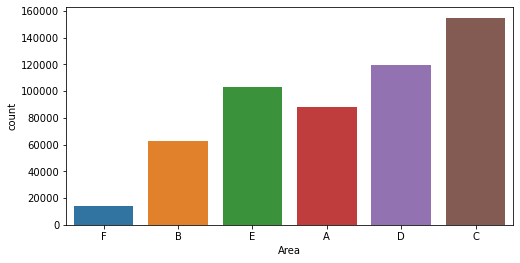

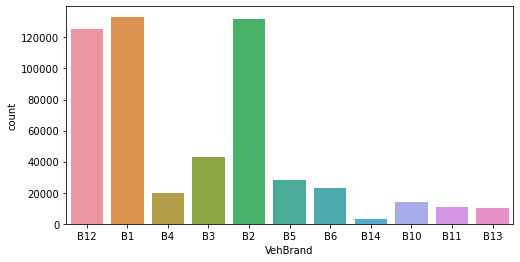

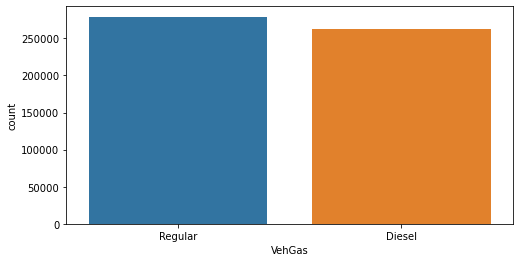

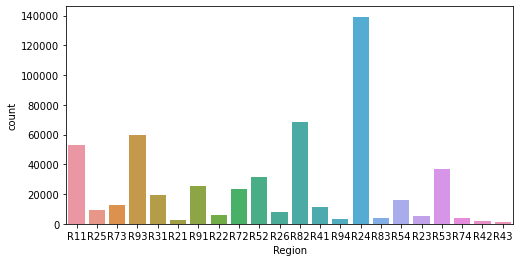

In [38]:
for col in df.select_dtypes(['object']).columns:
    plt.figure(figsize = (8,4))
    sns.countplot(x = df[col])
    plt.show();

<br><br>

<div class="alert alert-info">
  <strong>Bewertung von kategorischen Merkmalen</strong>
</div>

* Es gibt eine angemessene Anzahl von kategorialen Werten. Sie können für die Modellierung einhändig kodiert werden.

<br><br>

<br>[Return to the Outline](#outline) <br>

<br><br>

<a id='ch5'></a>

## 5. Model Building

In diesem Abschnitt, werden 
* die ML-Modelle erstellt, bewertet und verglichen. 
* Die ausgewählten Modelle werden abgestimmt. 
* Schließlich werden die endgültigen Vorhersagen erstellt.

<br>

**Methodik**

* Zur Vorhersage von Schadenhöhe/Exposition wird zunächst die Schadenhäufigkeit (SchadenNb/Exposition) vorhergesagt.

* Anschließend wird anhand der vorhergesagten Schadenhäufigkeit und der anderen unabhängigen Variablen die Schadenschwere (Schadenhöhe/SchadenNb) vorhergesagt.

* Schließlich wird die Schadenhöhe/Exposition vorhergesagt, indem 
  * (1) die Schadenhäufigkeit und die Schadenschwere multipliziert werden und 
  * (2) ein weiteres ML-Modell unter Verwendung der vorhergesagten Merkmale und der anderen unabhängigen Variablen erstellt wird. 
<br>  
<br>  
* Das beste Modell wird als endgültige Vorhersage ausgewählt.

<br><br><br>

<a id='ch5-0'></a>

### 5.0. Model Setup

Wir beginnen mit dem Import von Regressionsalgorithmen sowie von Vorverarbeitungs- und Metrikwerkzeugen.

In [39]:
# Importing Regression algorithms

from sklearn.linear_model import ElasticNet, PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Importing preprocessing and metrics tools

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.model_selection import ShuffleSplit, train_test_split


Wir definieren eine Funktion zur Aufzeichnung der Punktzahlen der Algorithmen.

In [40]:
# Defining a function to create regression models and record the scores in a table

result_table = pd.DataFrame(columns = ['model', 'MSLE', 'RMSE', 'MAE', 'R2'])


# Defining a function to test the models without tuning
def create_reg_model(model, sample_weight = None):
    """
    This function fit/predict the model to record scores.
    -
    To clean result_table use the following code:
    result_table = pd.DataFrame(columns = ['model','MSLE', 'RMSE', 'MAE', 'R2'])
    """
    print('-'*50, '\n', str(model)[:60])
    
    # Creating the model
    model.fit(X_train, y_train, sample_weight = sample_weight.iloc[train_index])
    y_pred = model.predict(X_test)
    
    # To avoid negative values
    y_pred[y_pred<0] = 0
    # Recording the result
    result_table.loc[len(result_table)] = [str(model)[:60], 
                                           mean_squared_log_error(y_test, y_pred), #MSLE
                                           np.sqrt(mean_squared_error(y_test, y_pred)),  #RMSE
                                           mean_absolute_error(y_test, y_pred),  #MAE
                                           r2_score(y_test, y_pred) #R2 score
                                                   ]  


<br><br><br>

<br>[Return to the Outline](#outline) <br>

<a id='ch5-1'></a>

### 5.1. Claim Frequency

In [41]:
# Copying dataset to be able to manipulate
df_model = df.copy()
df_model = df_model.reset_index(drop = True)

<br><br>

**Building Model**

In [42]:
# Defining dependent variable
y = df_model['ClaimFrequency']

# Creating train/test indices - 90%-10%
ss = ShuffleSplit(test_size=0.1, random_state=101)
train_index, test_index = next(ss.split(y))

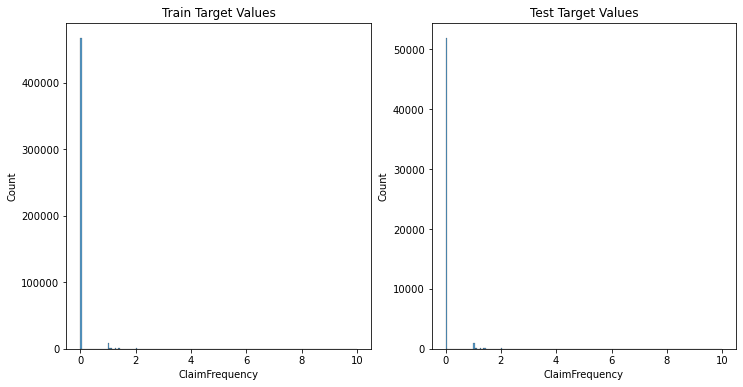

In [43]:
# Plotting train/test disributions of the target value

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.histplot(x = y.iloc[train_index], bins = 200, ax = ax[0])
ax[0].set_title('Train Target Values')
sns.histplot(x = y.iloc[test_index], bins = 200, ax = ax[1])
ax[1].set_title('Test Target Values')
plt.show()

<br>
<div class="alert alert-warning">
Die Claim Frequency hat eine Poisson-Verteilung. Daher können wir sowohl PoissonRegressor als auch baumbasierte Algorithmen verwenden. Wir werden die Merkmale der Versicherungsnehmer als Inputs verwenden. Außerdem verwenden wir 'Exposure' as sample_weight.
</div>

In [44]:
# Defining independent variables
X = df_model[['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']]

# One-hot Encoding categorical variables
X = pd.get_dummies(X)

# Splitting train/test variables
X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

# Scaling numerical variables
numeric_cols = ['VehAge', 'DrivAge', 'BonusMalus', 'Density']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

In [45]:
# Fitting all regression models and record the scores
regression_algorithms = [ElasticNet(), 
                         PoissonRegressor(), PoissonRegressor(alpha=1e-4),
                         TweedieRegressor(power=1), TweedieRegressor(power=1.5), TweedieRegressor(power=1.9),
                         
                         RandomForestRegressor(criterion= 'poisson'),

                         GradientBoostingRegressor(), HistGradientBoostingRegressor('poisson'),
                         
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1), 
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.5),
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.9),
                         
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1), 
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.5), 
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.9), 
                         
                         CatBoostRegressor(verbose=0), 
                         CatBoostRegressor(loss_function= 'Tweedie:variance_power=1.5', verbose=0)]


result_table = pd.DataFrame(columns = ['model','MSLE', 'RMSE', 'MAE', 'R2'])
for model in regression_algorithms:
    create_reg_model(model, sample_weight= df_model['Exposure'])

-------------------------------------------------- 
 ElasticNet()
-------------------------------------------------- 
 PoissonRegressor()
-------------------------------------------------- 
 PoissonRegressor(alpha=0.0001)
-------------------------------------------------- 
 TweedieRegressor(power=1)
-------------------------------------------------- 
 TweedieRegressor(power=1.5)
-------------------------------------------------- 
 TweedieRegressor(power=1.9)
-------------------------------------------------- 
 RandomForestRegressor(criterion='poisson')
-------------------------------------------------- 
 GradientBoostingRegressor()
-------------------------------------------------- 
 HistGradientBoostingRegressor(loss='poisson')
-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

---------------------------------

<br><br>

**Model Evaluation**

<AxesSubplot:ylabel='model'>

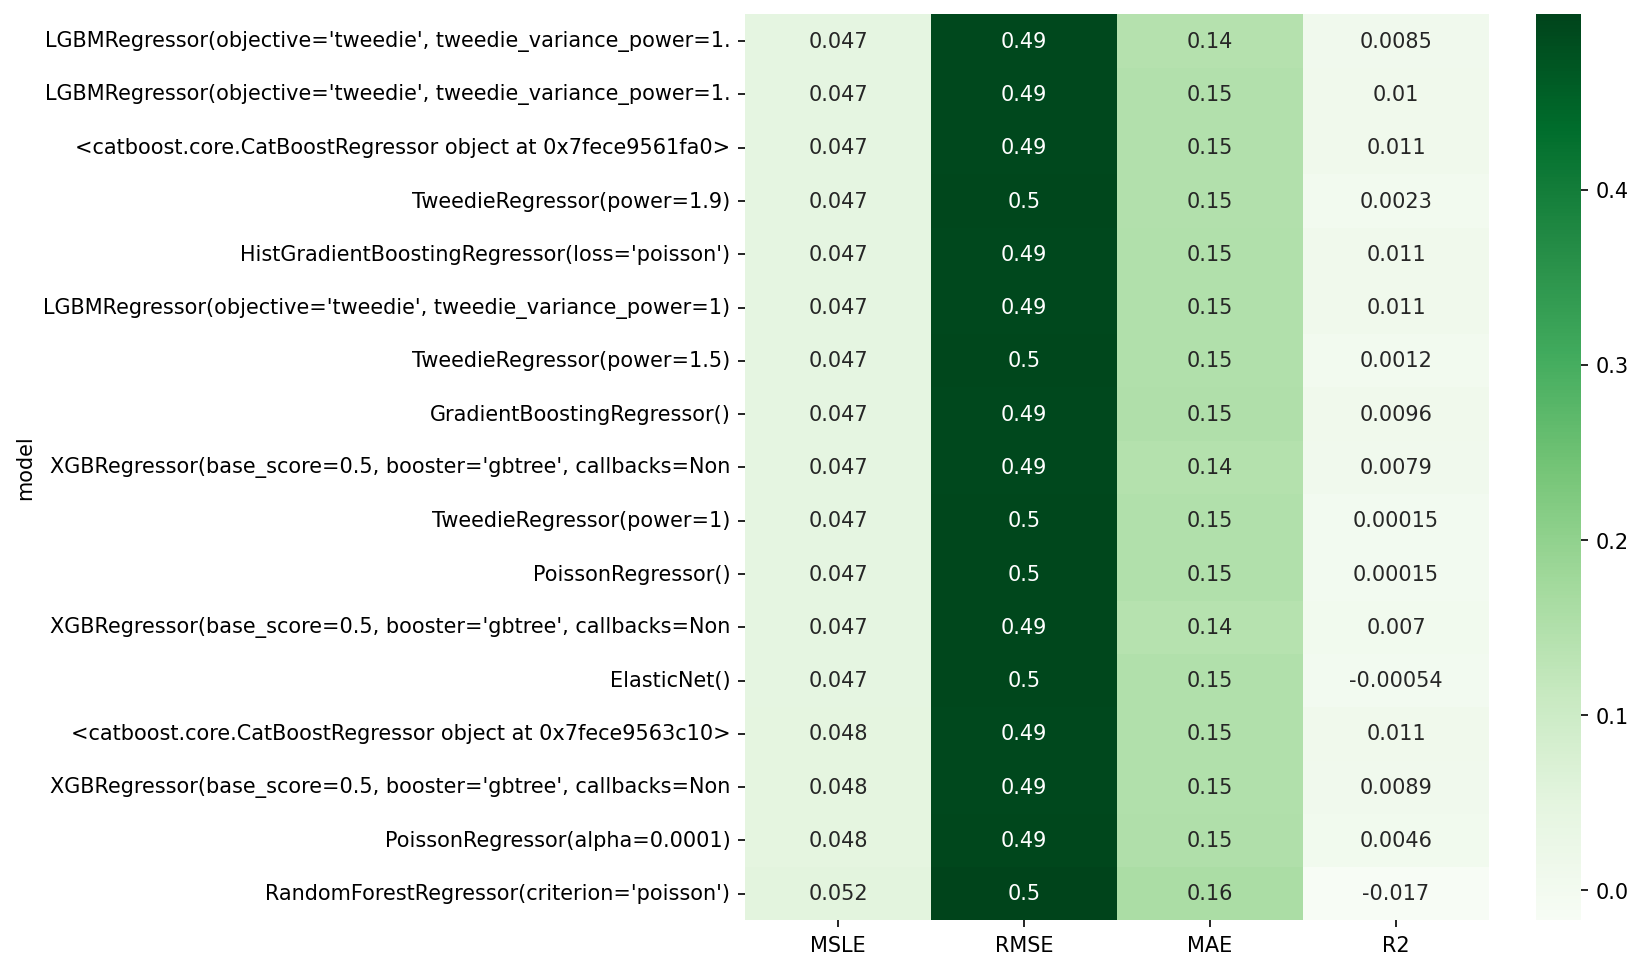

In [46]:
# Plotting the scores

plt.figure(figsize = (8,8), dpi = 150)
sns.heatmap(result_table.set_index('model').sort_values(by = 'MSLE', ascending = True), annot = True, cmap = 'Greens')

<br>
<div class="alert alert-warning">
R2 gibt die Anpassungsgüte an, doch der <b>R2-Wert</b> ist bei allen Algorithmen sehr niedrig. Wir können auch andere Metriken berücksichtigen. <b>MLSE</b> ist ein guter Indikator für exponentiell verteilte Daten.  Der LGBMRegressor erzielt in fast jeder Kategorie die besten Ergebnisse. Wir werden ihn also für die Abstimmung auswählen.
</div>

<br><br>

**Model Selection and Hyperparameter Tuning**

In [47]:
# Defining the selected model and getting parameters

model = LGBMRegressor()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

<br>

<div class="alert alert-danger">
  Es gibt viele Parameter, die wir einstellen können, aber das kostet zu viel Zeit. Wir wählen nur Tweedie_variance_power für einen Versuch aus.
</div>

In [48]:
# Defining tuning parameters

from sklearn.model_selection import GridSearchCV

param_grid = {
    'objective': ["tweedie"],
    'tweedie_variance_power': np.arange(1,2,0.1)
}

# Defining CV model

tuned_model = GridSearchCV(LGBMRegressor(), param_grid, scoring = 'neg_mean_squared_log_error', cv = 3)



In [49]:
# Fitting the CV model

tuned_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'objective': ['tweedie'],
                         'tweedie_variance_power': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_squared_log_error')

In [50]:
# Getting best parameters

tuned_model.best_params_

{'objective': 'tweedie', 'tweedie_variance_power': 1.7000000000000006}

<br><br>

**Results**

<br>
<div class="alert alert-warning">
Jetzt werden wir unser abgestimmtes Modell anpassen und sehen, wie gut es passt.
</div>

In [51]:
# Building the final model

claim_freq_model = LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.7)
claim_freq_model.fit(X_train,y_train, sample_weight=df_model.iloc[train_index]['Exposure'])
y_pred = claim_freq_model.predict(X_test)

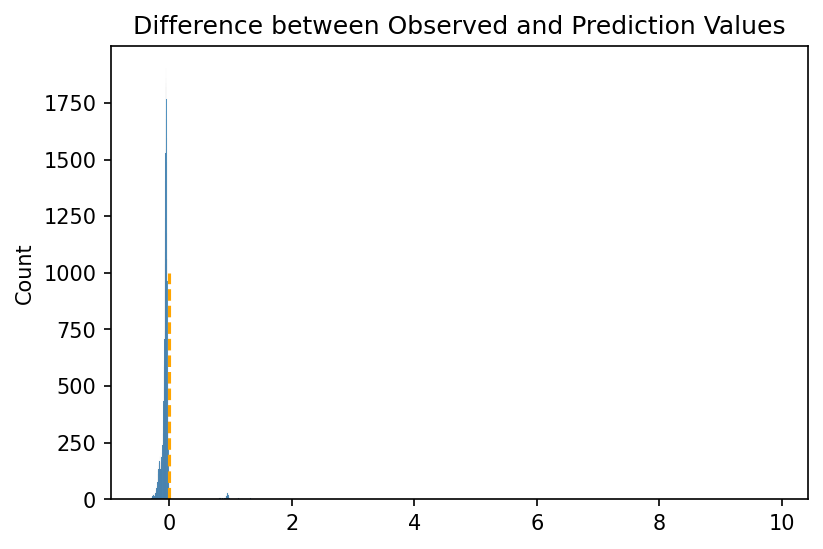

In [52]:
# Plotting the difference between predicted and test values

plt.figure(dpi = 150)
sns.histplot(y_test.values-y_pred)
plt.vlines(x = 0, ymin = 0, ymax = 1000, linestyles= "--", color = 'orange')
plt.title("Difference between Observed and Prediction Values");

<br>
<div class="alert alert-warning">
    Es gibt einige Extremwerte, aber die Differenz zwischen vorhergesagten und beobachteten Werten kumuliert sich meist um 0.
</div>

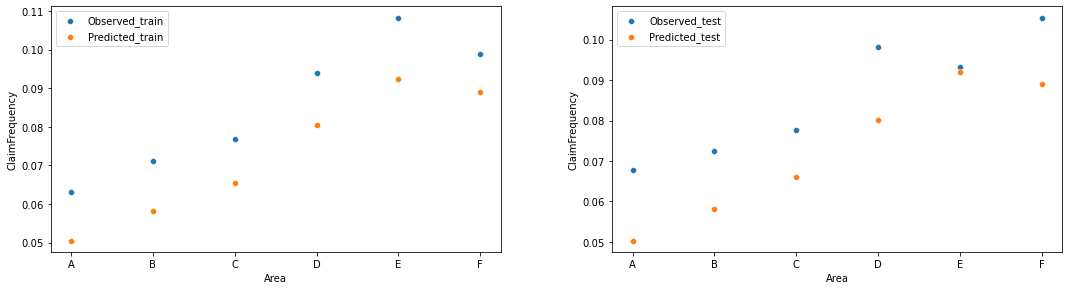

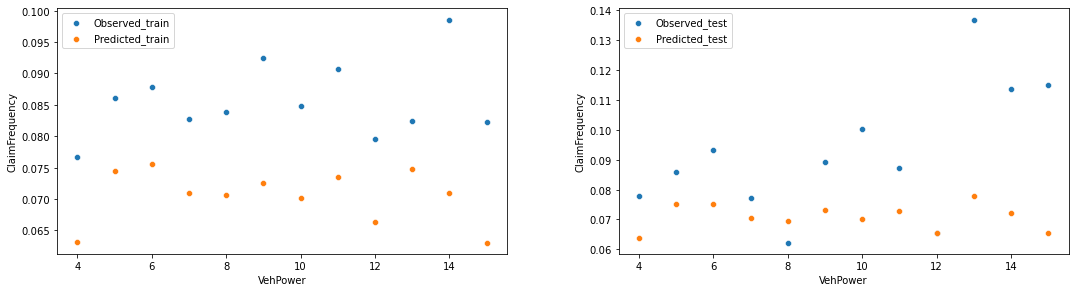

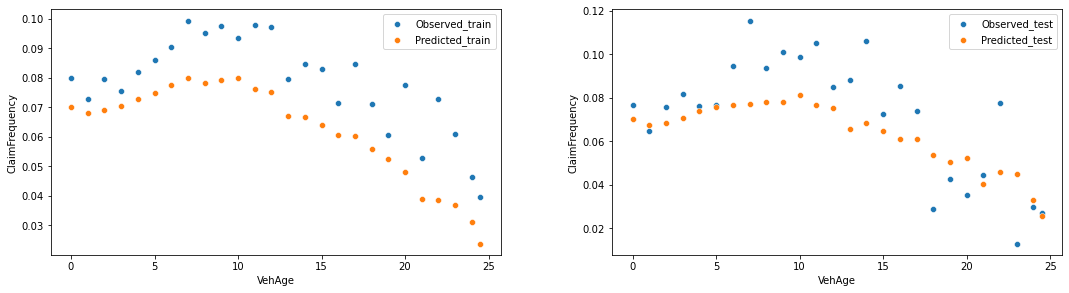

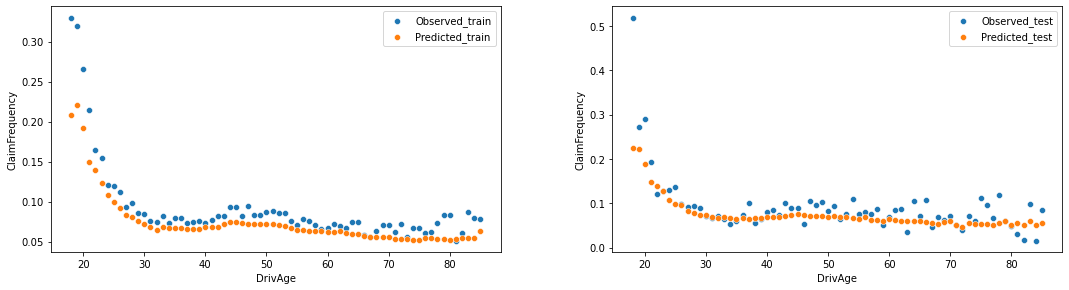

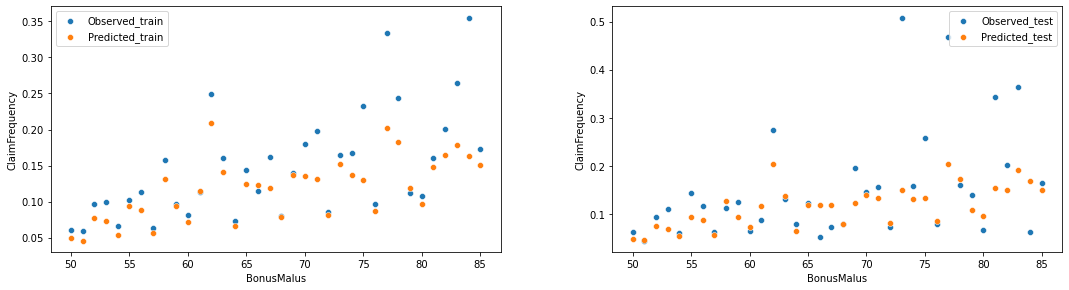

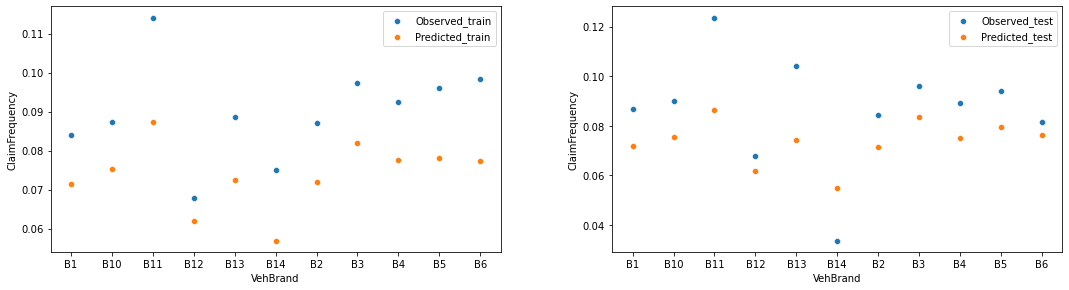

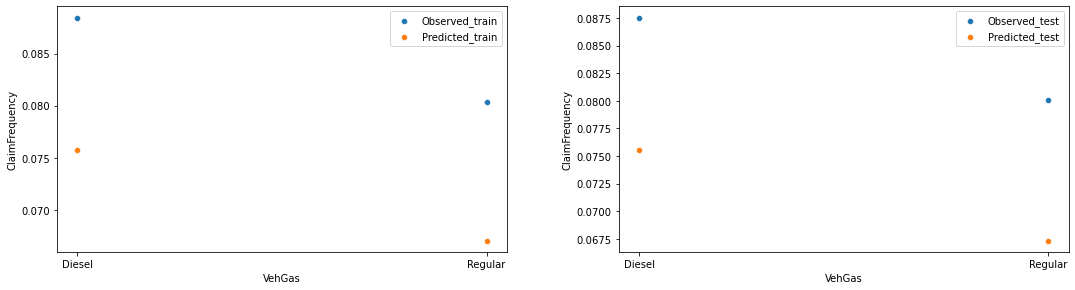

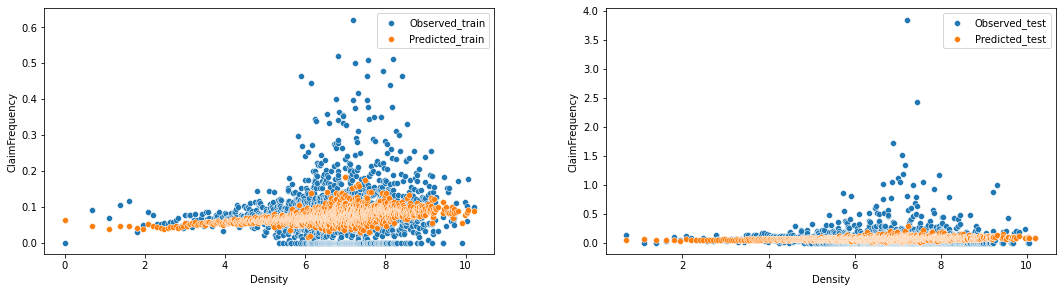

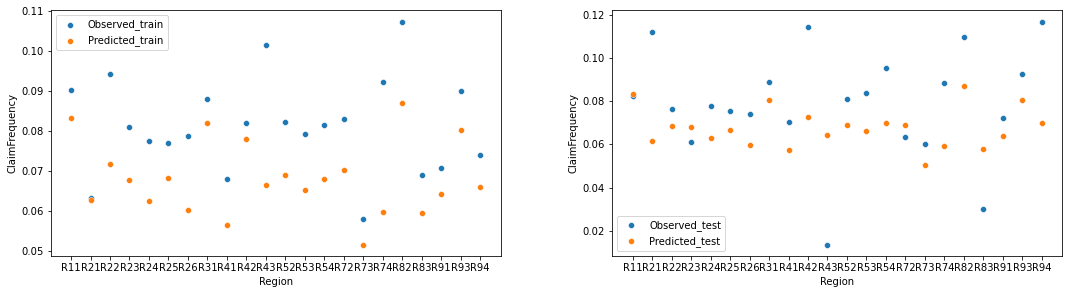

In [53]:
# Saving the prediction values for plotting
df_model['ClaimFreqPreds'] = claim_freq_model.predict(X)

# Plotting observed and predicted values for train/test
for col in ['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    fig.set_figwidth(16)
    
    sns.scatterplot(x = df_model.loc[train_index].groupby(col).mean().index, 
                    y = df_model.loc[train_index].groupby(col).mean()['ClaimFrequency'], 
                    ax = ax[0], label = 'Observed_train')
    sns.scatterplot(x = df_model.loc[train_index].groupby(col).mean().index, 
                    y = df_model.loc[train_index].groupby(col).mean()['ClaimFreqPreds'], 
                    ax = ax[0], label = 'Predicted_train')
   
    sns.scatterplot(x = df_model.loc[test_index].groupby(col).mean().index, 
                    y = df_model.loc[test_index].groupby(col).mean()['ClaimFrequency'], 
                    ax = ax[1], label = 'Observed_test')
    sns.scatterplot(x = df_model.loc[test_index].groupby(col).mean().index, 
                    y = df_model.loc[test_index].groupby(col).mean()['ClaimFreqPreds'], 
                    ax = ax[1], label = 'Predicted_test')
    
    plt.legend()
    plt.show();

<br>
<div class="alert alert-warning">
Es ist klar, dass das Modell keine Extremwerte erfassen kann, aber im Allgemeinen ist es nahe genug dran, die beobachteten Werte vorherzusagen.
</div>

<br><br>

In [54]:
print("Test Data Evaluation\n","-"*20)
print(f"Observed    Mean:  {y_test.mean():.4f} | Standard Dev: {y_test.std():.4f}")
print(f"Predictions Mean:  {y_pred.mean():.4f} | Standard Dev: {y_pred.std():.4f}")

Test Data Evaluation
 --------------------
Observed    Mean:  0.0837 | Standard Dev: 0.4957
Predictions Mean:  0.0713 | Standard Dev: 0.0470


<br><br>

**Saving Results**

In [55]:
# Saving final predictions to the original dataframe
df['ClaimFreqPreds'] = df_model['ClaimFreqPreds'].values

In [56]:
df.head()

ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                          
139          1      0.75    F      7.0     1.0     61.0        50.0      B12   
190          1      0.14    B     12.0     5.0     50.0        60.0      B12   
414          1      0.14    E      4.0     0.0     36.0        85.0      B12   
424          2      0.62    F     10.0     0.0     51.0        85.0      B12   
463          1      0.31    A      5.0     0.0     45.0        50.0      B12   

        VehGas    Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
IDpol                                                                          
139    Regular  10.203592    R11       303.00         303.00        1.333333   
190     Diesel   4.025352    R25      1981.84        1981.84        7.142857   
414    Regular   8.474703    R11      1456.55        1456.55        7.142857   
424    Regular  10.203592    R11     10834.00        5417.00        3.225806   
463    Regular   2.484907    R73      3986.67        3986.67        3.225806   

       ClaimAmountPerExp  ClaimFreqPreds  
IDpol                                     
139           404.000000        0.060159  
190         14156.000000        0.091979  
414         10403.928571        0.090665  
424         17474.193548        0.131912  
463         12860.225806        0.042136

<br><br>

**Feature Importance**

In [57]:
# Creating a dataframe for feature importances
imp_feats = pd.DataFrame(data = claim_freq_model.feature_importances_,
                         index = X.columns,columns = ['Feature Importance']).sort_values("Feature Importance")

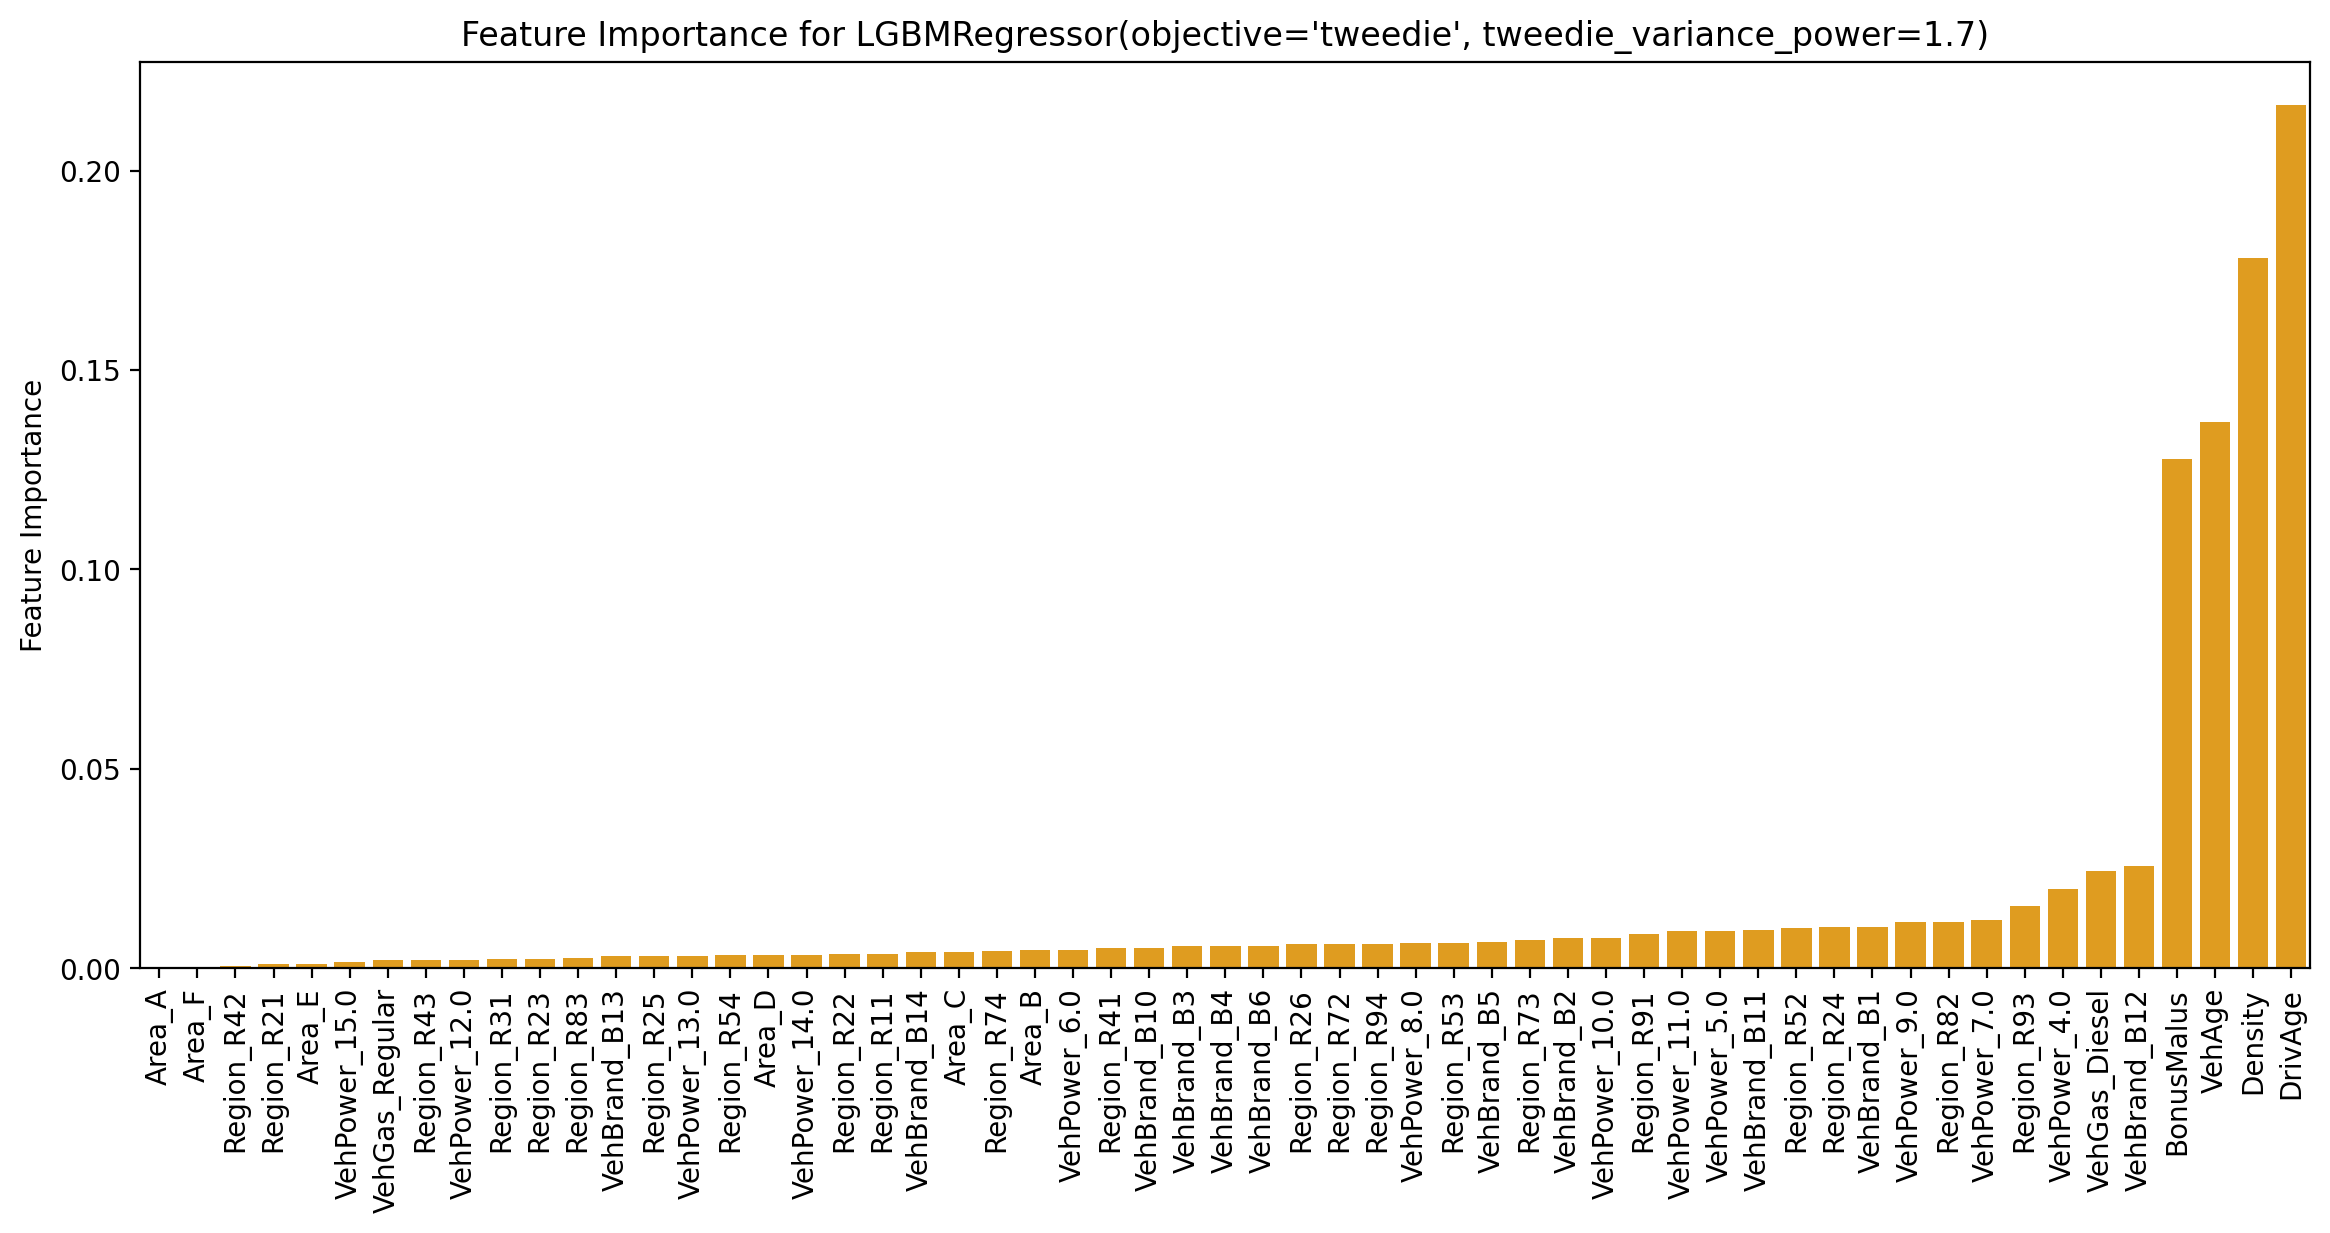

In [58]:
# Plotting feature importances

plt.figure(figsize = (14,6), dpi = 200)
sns.barplot(data = imp_feats/imp_feats['Feature Importance'].sum(),
            x = imp_feats.index,
            y = 'Feature Importance', color = 'orange')
plt.xticks(rotation = 90)
plt.title(f"Feature Importance for {claim_freq_model}");

<div class="alert alert-info">
  <strong>Bewertung der Bedeutung von Merkmalen</strong>
</div>

* **Drivage**, **Density**, **VehAge** und **BonusMalus** sind wichtigste Merkmal und hat eine Bedeutung von ungefähr 70 % im LGBMRegressor. 
* Dann kommen die Fahrzeug- und Area-eigenschaften

<br><br>

<br>[Return to the Outline](#outline) <br>

<br><br><br>

<a id='ch5-2'></a>

### 5.2. Claim Severity

In [59]:
# Copying dataset to be able to manipulate
df_model = df.copy()
df_model = df_model.reset_index(drop = True)

In [60]:
df_model.head()

ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0        1      0.75    F      7.0     1.0     61.0        50.0      B12   
1        1      0.14    B     12.0     5.0     50.0        60.0      B12   
2        1      0.14    E      4.0     0.0     36.0        85.0      B12   
3        2      0.62    F     10.0     0.0     51.0        85.0      B12   
4        1      0.31    A      5.0     0.0     45.0        50.0      B12   

    VehGas    Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
0  Regular  10.203592    R11       303.00         303.00        1.333333   
1   Diesel   4.025352    R25      1981.84        1981.84        7.142857   
2  Regular   8.474703    R11      1456.55        1456.55        7.142857   
3  Regular  10.203592    R11     10834.00        5417.00        3.225806   
4  Regular   2.484907    R73      3986.67        3986.67        3.225806   

   ClaimAmountPerExp  ClaimFreqPreds  
0         404.000000        0.060159  
1       14156.000000        0.091979  
2       10403.928571        0.090665  
3       17474.193548        0.131912  
4       12860.225806        0.042136

<br><br>

**Definition des ClaimSeverity-Modells**

* Wir beginnen mit dem Herausfiltern von 0 ClaimAmount, weil 
  * wir versuchen, die ClaimAmount pro Schadenfall vorherzusagen und
  * die ClaimSeverity wird als Gamma-Verteilung modelliert, die streng positive Werte erfordert.
* Wir können die vorhergesagte ClaimFrequency als unabhängige Variable verwenden, da wir sie bereits berechnet haben. Dies kann dazu beitragen, die Modellwerte zu erhöhen.

In [61]:
# Filtering out the rows having 0 Claim Amounts
df_model = df_model[df_model['ClaimAmount'] > 0]

In [62]:
# Defining dependent variable
y = df_model['ClaimSeverity']

# Creating train/test indices - 90%-10%
ss = ShuffleSplit(test_size=0.1, random_state=101)
train_index, test_index = next(ss.split(y))

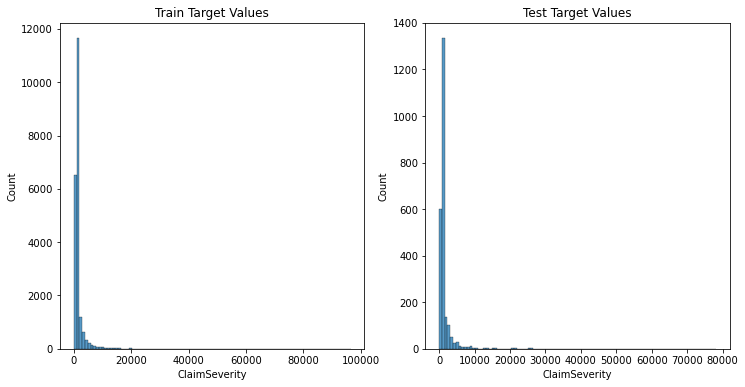

In [63]:
# Plotting train/test disributions of the target value

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.histplot(x = y.iloc[train_index], bins = 100, ax = ax[0])
ax[0].set_title('Train Target Values')
sns.histplot(x = y.iloc[test_index], bins = 100, ax = ax[1])
ax[1].set_title('Test Target Values')
plt.show()

<br>
<div class="alert alert-warning">
Die Claim Severity hat eine Gamma-Verteilung. Daher können wir sowohl GammaRegressor als auch baumbasierte Algorithmen verwenden. Wir werden die Merkmale der Versicherungsnehmer und vorhergesagte ClaimFrequency als Inputs verwenden.
</div>

In [64]:
# Defining independent variables
# We add also Predicted Claim Severity as independent variable to increase prediction scores.
X = df_model[['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimFreqPreds']]

# One-hot Encoding categorical variables
X = pd.get_dummies(X)

# Splitting train/test variables
X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

# Scaling numerical variables
numeric_cols = ['VehAge', 'DrivAge', 'BonusMalus', 'Density','ClaimFreqPreds']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

In [65]:
# Fitting all regression models and record the scores
regression_algorithms = [ElasticNet(), 
                         GammaRegressor(), GammaRegressor(alpha=10),
                         TweedieRegressor(power=1), TweedieRegressor(power=1.5), TweedieRegressor(power=1.9),

                         GradientBoostingRegressor(), HistGradientBoostingRegressor('poisson'),
                         
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.1), 
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.5),
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.9),
                         
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1), 
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.5), 
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.9), 
                         
                         CatBoostRegressor(verbose=0), 
                         CatBoostRegressor(loss_function= 'Tweedie:variance_power=1.5', verbose=0),
                         
                         RandomForestRegressor(criterion= 'poisson')]


result_table = pd.DataFrame(columns = ['model','MSLE', 'RMSE', 'MAE', 'R2'])
for model in regression_algorithms:
    create_reg_model(model, sample_weight= df_model['Exposure'])

-------------------------------------------------- 
 ElasticNet()
-------------------------------------------------- 
 GammaRegressor()
-------------------------------------------------- 
 GammaRegressor(alpha=10)
-------------------------------------------------- 
 TweedieRegressor(power=1)
-------------------------------------------------- 
 TweedieRegressor(power=1.5)
-------------------------------------------------- 
 TweedieRegressor(power=1.9)
-------------------------------------------------- 
 GradientBoostingRegressor()
-------------------------------------------------- 
 HistGradientBoostingRegressor(loss='poisson')
-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-----------------------

<br><br>

**Model Evaluation**

<AxesSubplot:ylabel='model'>

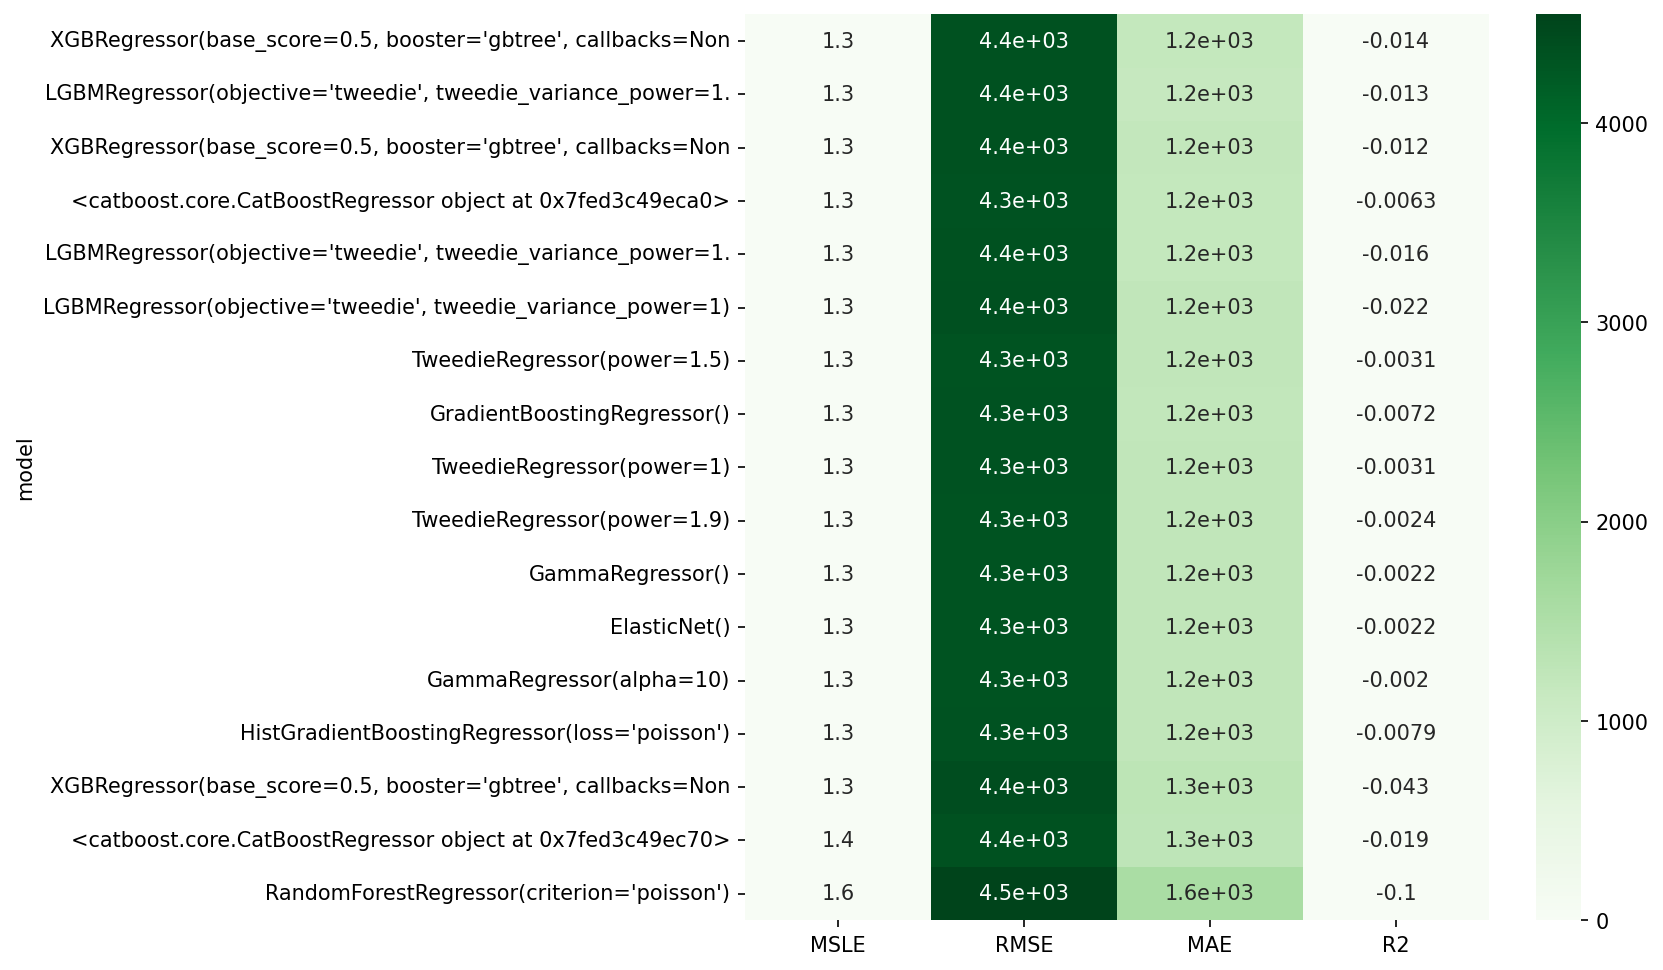

In [66]:
# Plotting the scores

plt.figure(figsize = (8,8), dpi = 150)
sns.heatmap(result_table.set_index('model').sort_values(by = 'MSLE', ascending = True), annot = True, cmap = 'Greens')

<br><br>

<br>
<div class="alert alert-warning">
XGBRegressor erweist sich als das beste MSLE Scoring-Modell für ClaimSeverity. Wir werden also dieses Modell abstimmen.
</div>

<br><br>

**Model Selection and Hyperparameter Tuning**

In [67]:
# Defining the selected model and getting parameters
model = XGBRegressor()
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

<br>

<div class="alert alert-danger">
  Es gibt viele Parameter, die wir einstellen können, aber das kostet zu viel Zeit. Wir wählen 2 von ihnen für einen Versuch aus.
</div>

In [68]:
# Defining tuning parameters

param_grid = {
    'objective': ["reg:tweedie"],
    'tweedie_variance_power': np.arange(1,2,0.1)
}

# Defining CV model

tuned_model = GridSearchCV(XGBRegressor(), param_grid, scoring = 'neg_mean_squared_log_error', cv = 3)



In [69]:
# Fitting the CV model

tuned_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [70]:
# Getting best parameters

tuned_model.best_params_

{'objective': 'reg:tweedie', 'tweedie_variance_power': 1.9000000000000008}

<br><br>

**Results**

<br>
<div class="alert alert-warning">
Jetzt werden wir unser abgestimmtes Modell anpassen und sehen, wie gut es passt.
</div>

In [71]:
# Building the final model
claim_severity_model = XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.9)
claim_severity_model.fit(X_train,y_train, sample_weight = df_model.iloc[train_index]['Exposure'])
y_pred = claim_severity_model.predict(X_test)

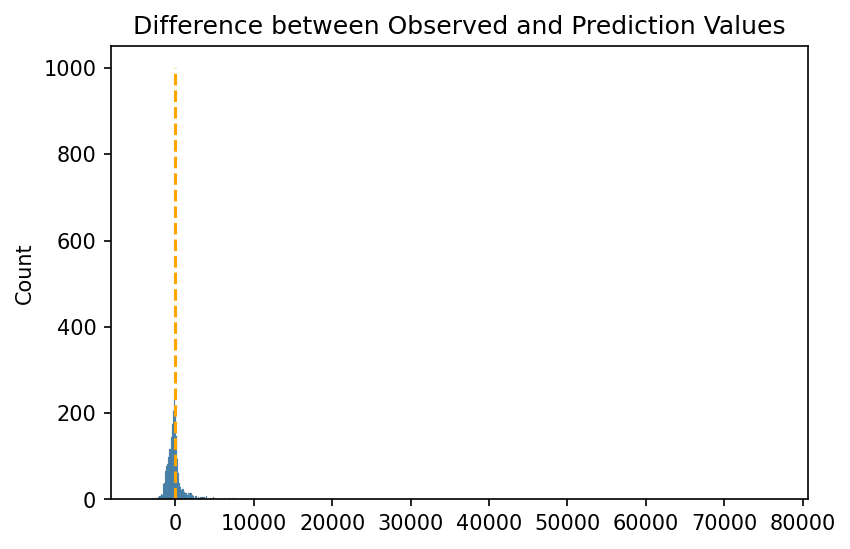

In [72]:
# Plotting the difference between predicted and test values

plt.figure(dpi = 150)
sns.histplot(y_test.values-y_pred)
plt.vlines(x = 0, ymin = 0, ymax = 1000, linestyles= "--", color = 'orange')
plt.title("Difference between Observed and Prediction Values");

<br>
<div class="alert alert-warning">
    Es gibt einige Extremwerte, aber die Differenz zwischen vorhergesagten und beobachteten Werten kumuliert sich meist um 0.
</div>

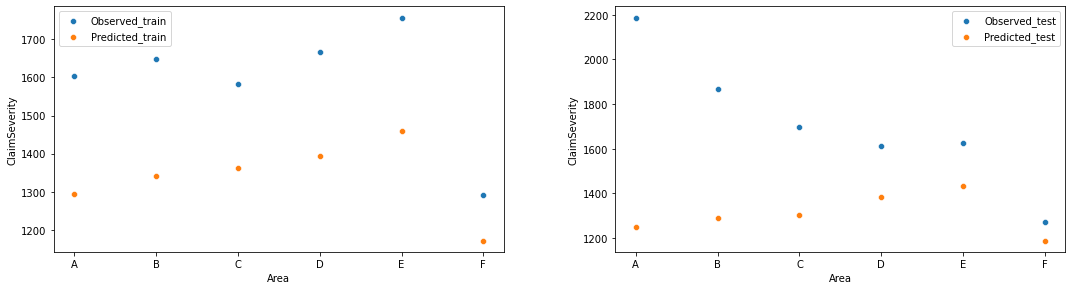

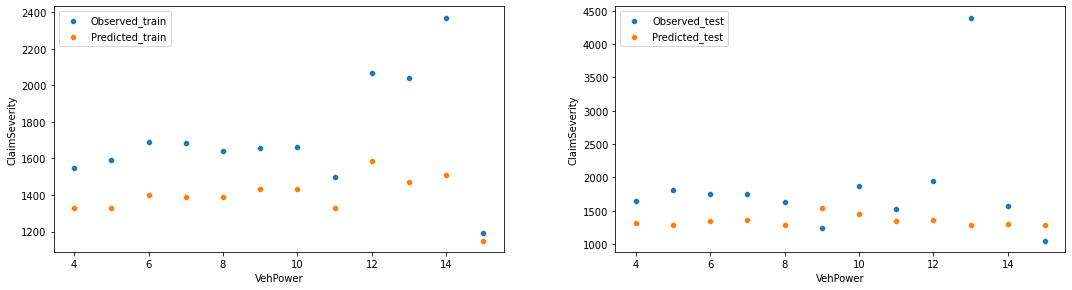

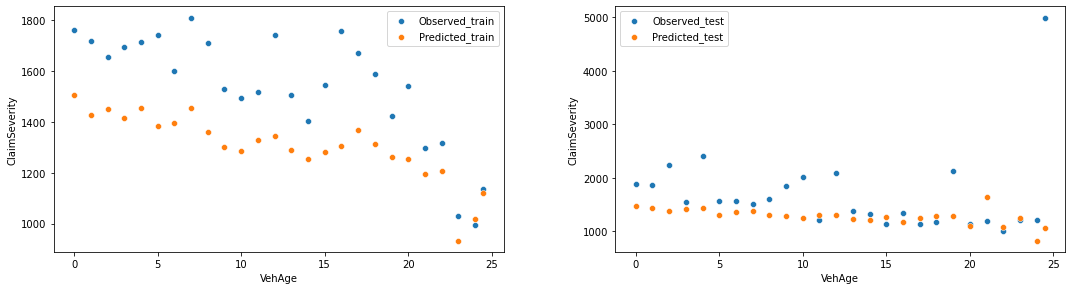

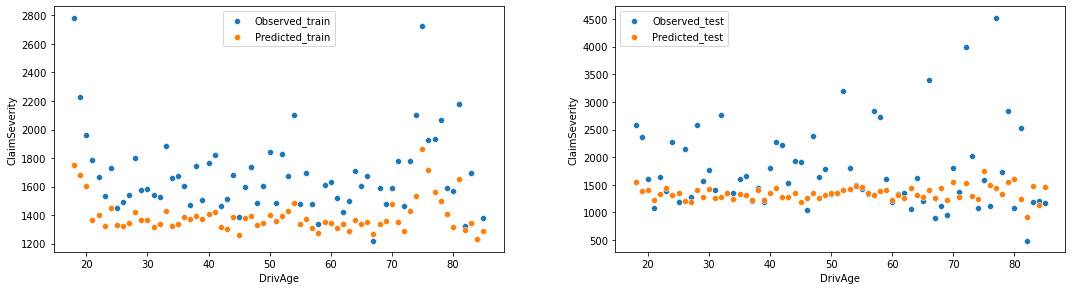

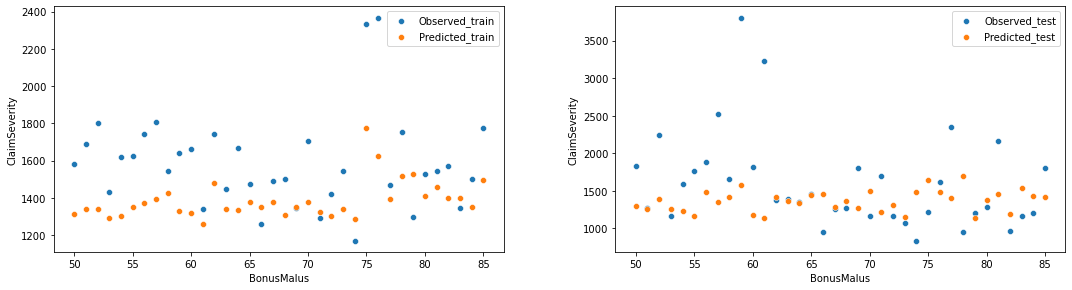

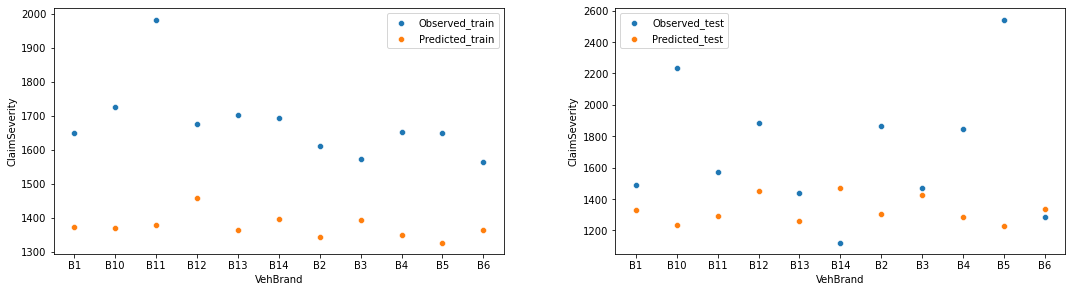

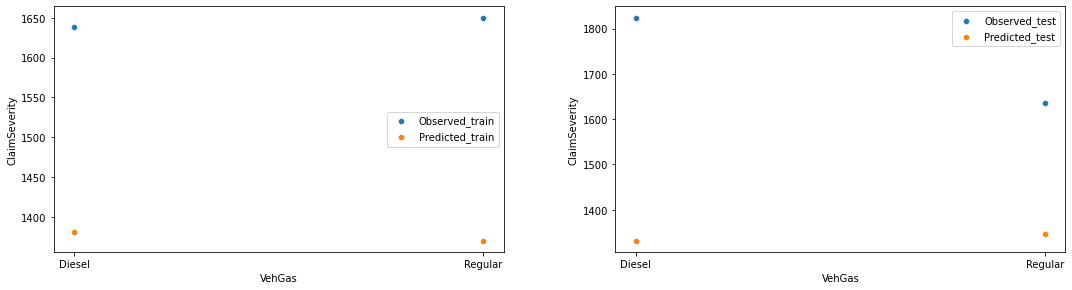

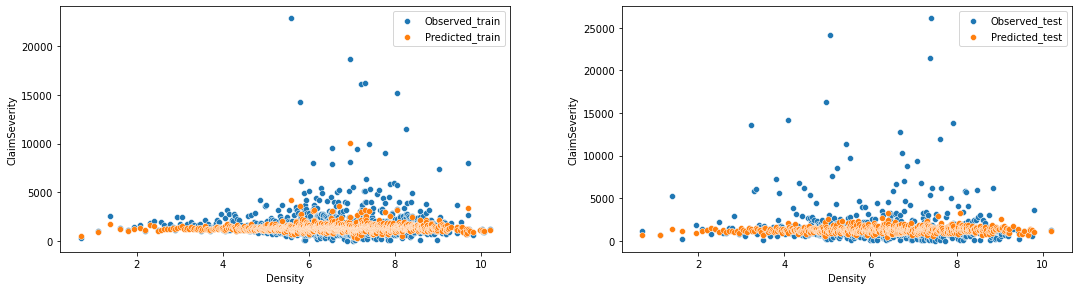

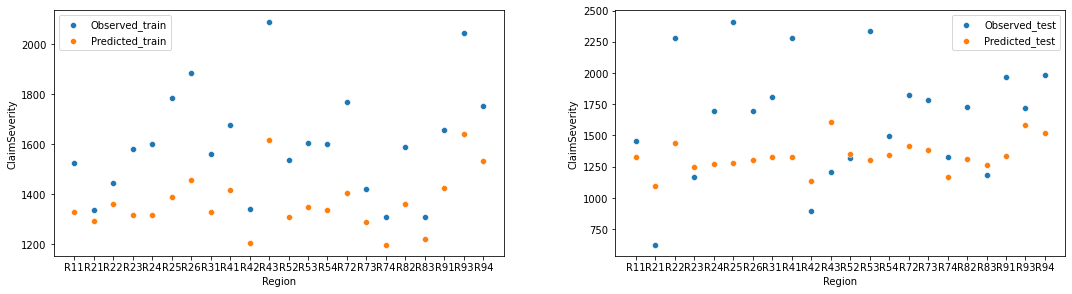

In [73]:
# Saving the prediction values for plotting
df_model['ClaimSeverityPreds'] = claim_severity_model.predict(X)

# Plotting observed and predicted values for train/test
for col in ['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    fig.set_figwidth(16)
    
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimSeverity'], 
                    ax = ax[0], label = 'Observed_train')
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimSeverityPreds'], 
                    ax = ax[0], label = 'Predicted_train')
   
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimSeverity'], 
                    ax = ax[1], label = 'Observed_test')
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimSeverityPreds'], 
                    ax = ax[1], label = 'Predicted_test')
    
    plt.legend()
    plt.show()

<br>
<div class="alert alert-warning">
Es ist klar, dass das Modell keine Extremwerte erfassen kann, aber im Allgemeinen ist es nahe genug dran, die beobachteten Werte vorherzusagen.
</div>

<br><br>

In [74]:
print("Test Data Evaluation\n","-"*20)
print(f"Observed     Mean:  {y_test.mean():.4f} | Standard Dev: {y_test.std():.4f}")
print(f"Predictions  Mean:  {y_pred.mean():.4f} | Standard Dev: {y_pred.std():.4f}")

Test Data Evaluation
 --------------------
Observed     Mean:  1735.5898 | Standard Dev: 4326.9417
Predictions  Mean:  1338.8918 | Standard Dev: 424.8460


<br><br>

**Saving Results**

* Wir haben die Zeilen mit 0 Forderungsbeträgen entfernt, um unser Modell zu erstellen. 
* Jetzt sollten wir X für den ursprünglichen Datenrahmen neu definieren und unser Modell verwenden, um für alle IDs Vorhersagen zu treffen. 

In [75]:
# Defining independent variables
X = df[['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimFreqPreds']]

# One-hot Encoding categorical variables
X = pd.get_dummies(X)

# Scaling numerical variables
numeric_cols = ['VehAge', 'DrivAge', 'BonusMalus', 'Density','ClaimFreqPreds']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [76]:
# Saving final predictions to the original dataframe
df['ClaimSeverityPreds'] = claim_severity_model.predict(X)

In [77]:
df.head()

ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                          
139          1      0.75    F      7.0     1.0     61.0        50.0      B12   
190          1      0.14    B     12.0     5.0     50.0        60.0      B12   
414          1      0.14    E      4.0     0.0     36.0        85.0      B12   
424          2      0.62    F     10.0     0.0     51.0        85.0      B12   
463          1      0.31    A      5.0     0.0     45.0        50.0      B12   

        VehGas    Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
IDpol                                                                          
139    Regular  10.203592    R11       303.00         303.00        1.333333   
190     Diesel   4.025352    R25      1981.84        1981.84        7.142857   
414    Regular   8.474703    R11      1456.55        1456.55        7.142857   
424    Regular  10.203592    R11     10834.00        5417.00        3.225806   
463    Regular   2.484907    R73      3986.67        3986.67        3.225806   

       ClaimAmountPerExp  ClaimFreqPreds  ClaimSeverityPreds  
IDpol                                                         
139           404.000000        0.060159         1716.935913  
190         14156.000000        0.091979          999.798889  
414         10403.928571        0.090665         1396.231201  
424         17474.193548        0.131912         2322.012939  
463         12860.225806        0.042136         1154.575439

<br><br>

**Feature Importance**

In [78]:
# Creating a dataframe for feature importances
imp_feats = pd.DataFrame(data = claim_severity_model.feature_importances_,
                         index = X.columns,columns = ['Feature Importance']).sort_values("Feature Importance")

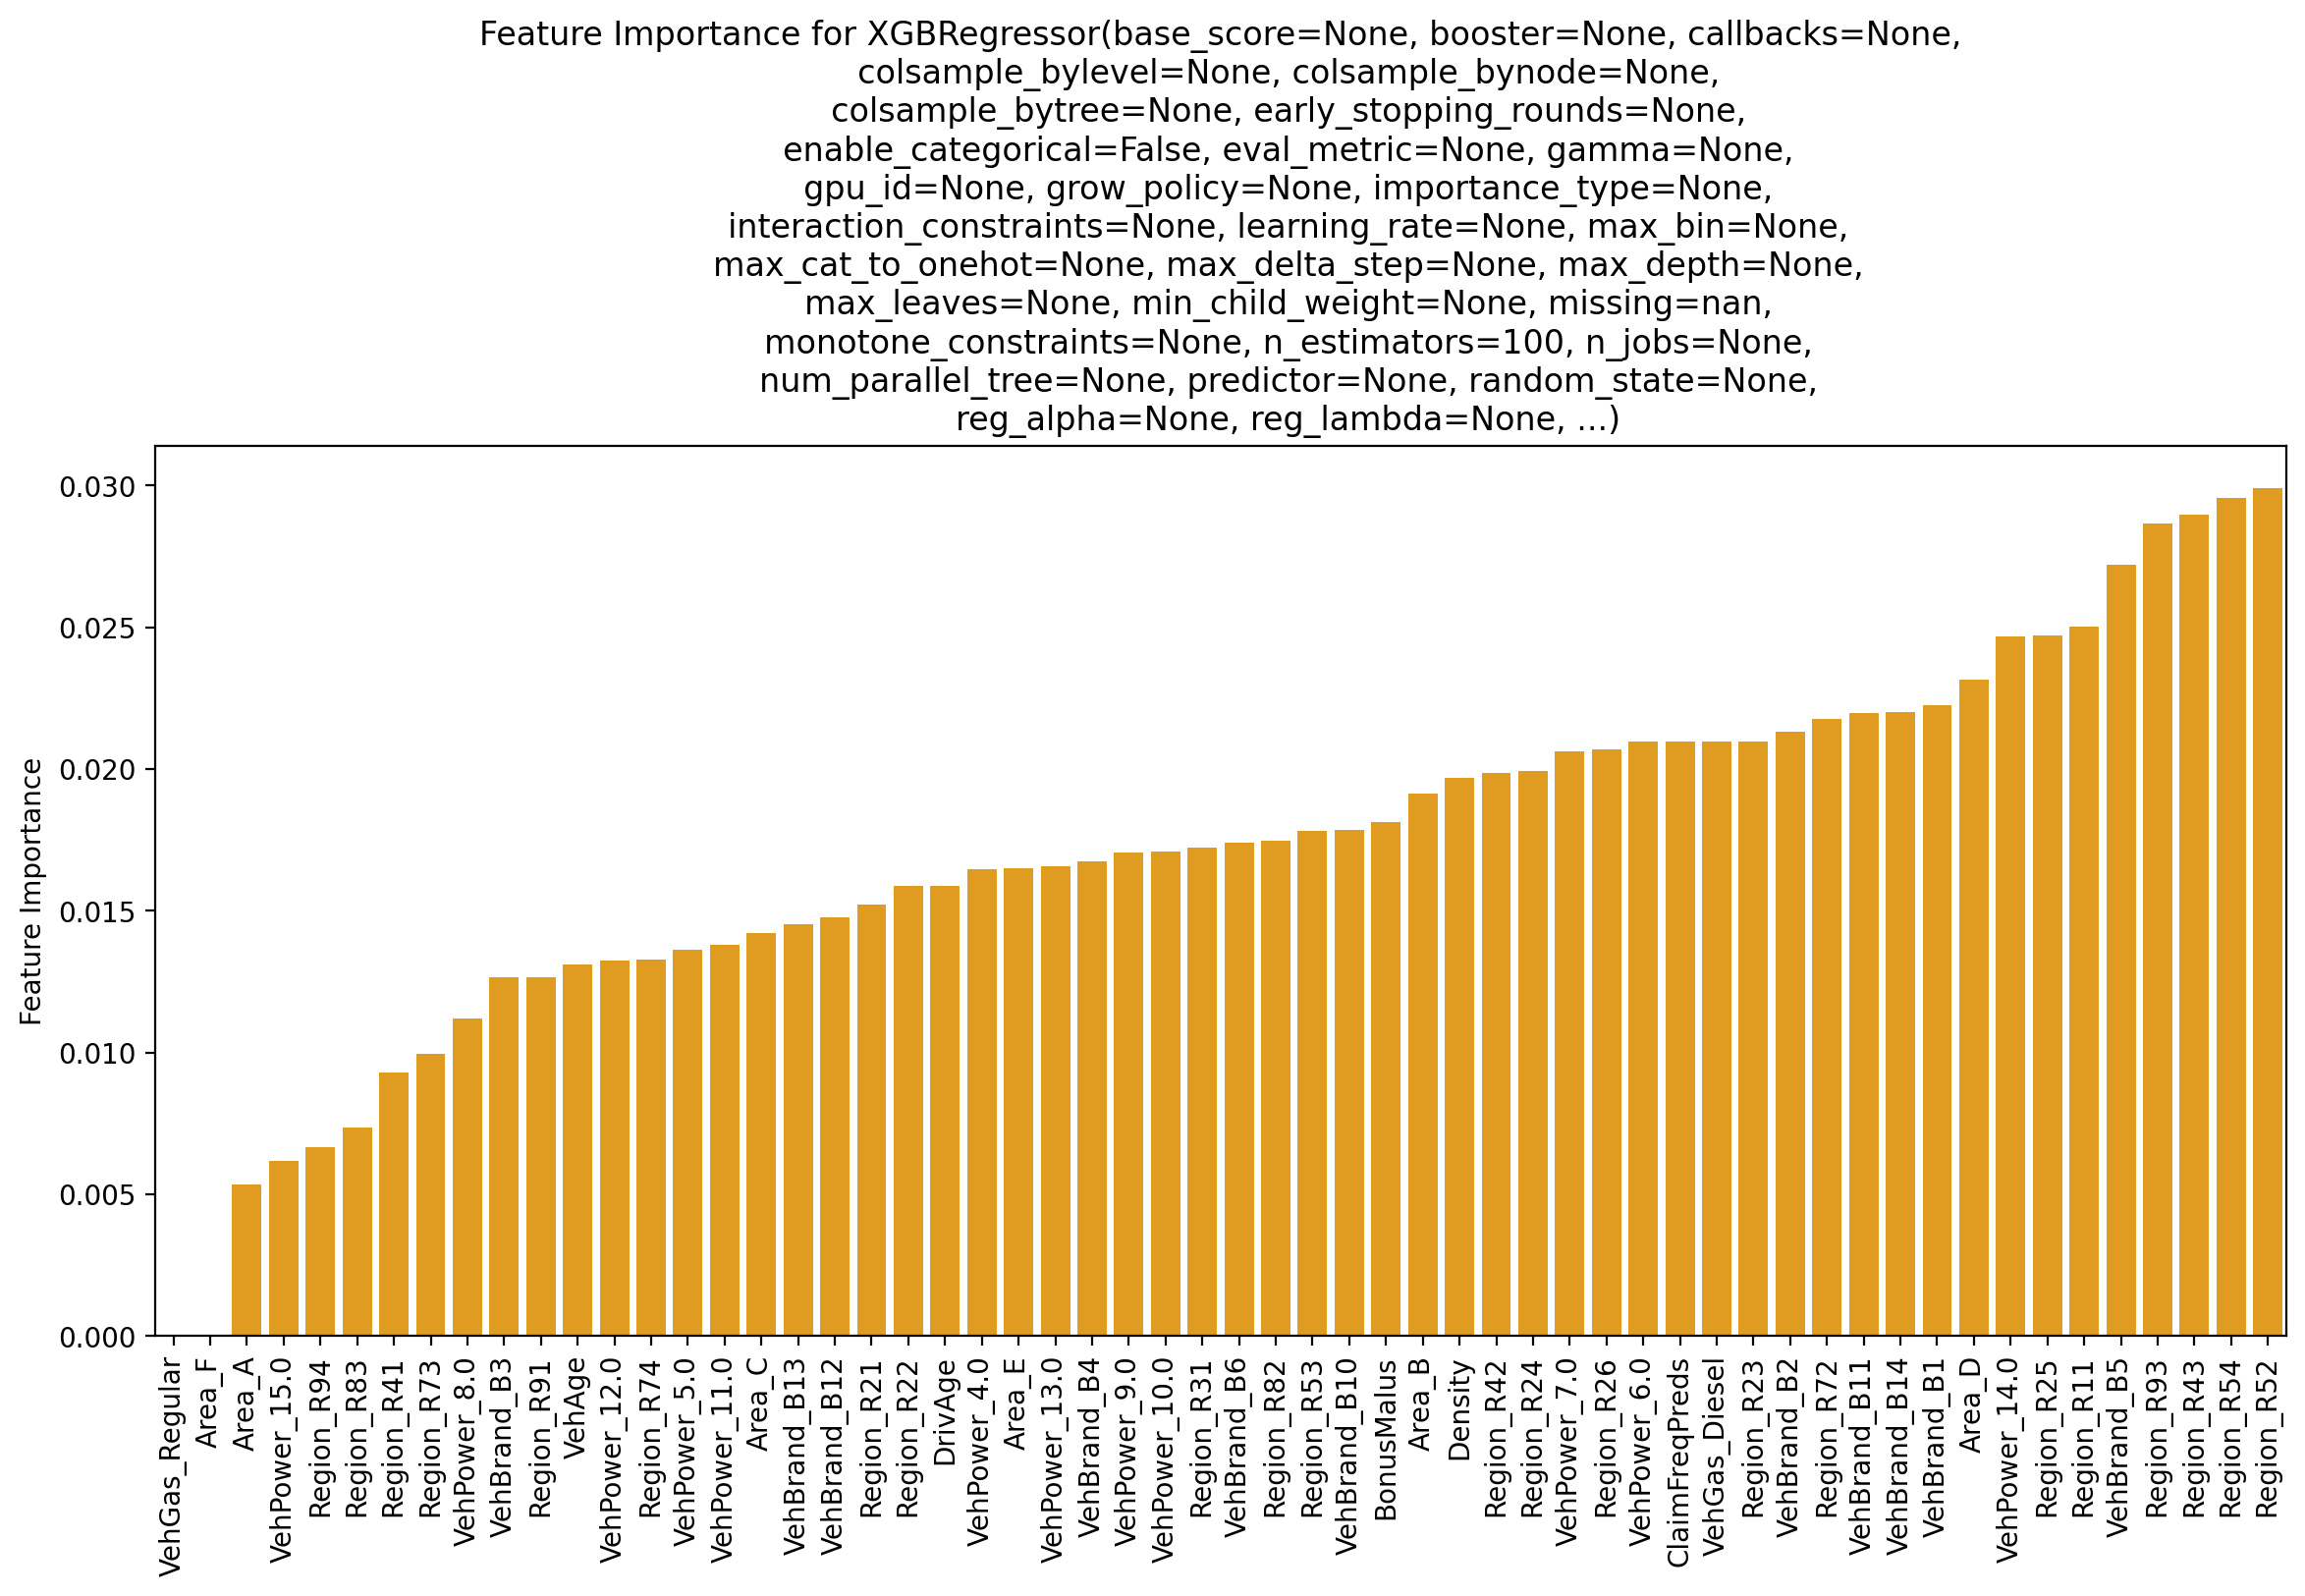

In [79]:
# Plotting feature importances

plt.figure(figsize = (14,6), dpi = 200)
sns.barplot(data = imp_feats,
            x = imp_feats.index,
            y = 'Feature Importance', color = 'orange')
plt.xticks(rotation = 90)
plt.title(f"Feature Importance for {model}");

<div class="alert alert-info">
  <strong>Bewertung der Bedeutung von Merkmalen</strong>
</div>

* Regionen und Fahrzeugeigenschaften sind die wichtigsten Faktoren in XGBRegressor.

<br><br>

<br>[Return to the Outline](#outline) <br>

<br><br><br>

<a id='ch5-3'></a>

### 5.3. Claim Amount / Exposure

* In diesem Abschnitt wird die ClaimAmount/Exposure vorhergesagt, indem 
  * (1) die Schadenhäufigkeit und die Schadenschwere multipliziert werden und 
  * (2) ein weiteres ML-Modell unter Verwendung der vorhergesagten Merkmale und der anderen unabhängigen Variablen erstellt wird. 

<a id='ch5-3-1'></a>

#### 5.3.1. Method I

$Claim Severity = \frac{Claim Amount}{Claim Number}$

$Claim Frequency = \frac{Claim Number}{Exposure}$

$\frac{Claim Amount}{Exposure} \ = Claim\ Severity  \ x\  Claim Frequency = \frac{Claim Amount}{Claim Number}  \ x\ \frac{Claim Number}{Exposure} $


In [80]:
# Multiplying claim severity with claim frequencies to get claim amounts/exposure
df['ClaimAmountPerExpPreds'] = df['ClaimSeverityPreds'] * df['ClaimFreqPreds']

In [81]:
df.head()

ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                          
139          1      0.75    F      7.0     1.0     61.0        50.0      B12   
190          1      0.14    B     12.0     5.0     50.0        60.0      B12   
414          1      0.14    E      4.0     0.0     36.0        85.0      B12   
424          2      0.62    F     10.0     0.0     51.0        85.0      B12   
463          1      0.31    A      5.0     0.0     45.0        50.0      B12   

        VehGas    Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
IDpol                                                                          
139    Regular  10.203592    R11       303.00         303.00        1.333333   
190     Diesel   4.025352    R25      1981.84        1981.84        7.142857   
414    Regular   8.474703    R11      1456.55        1456.55        7.142857   
424    Regular  10.203592    R11     10834.00        5417.00        3.225806   
463    Regular   2.484907    R73      3986.67        3986.67        3.225806   

       ClaimAmountPerExp  ClaimFreqPreds  ClaimSeverityPreds  \
IDpol                                                          
139           404.000000        0.060159         1716.935913   
190         14156.000000        0.091979          999.798889   
414         10403.928571        0.090665         1396.231201   
424         17474.193548        0.131912         2322.012939   
463         12860.225806        0.042136         1154.575439   

       ClaimAmountPerExpPreds  
IDpol                          
139                103.289075  
190                 91.960062  
414                126.589768  
424                306.302303  
463                 48.649222

<br><br>

**Results**

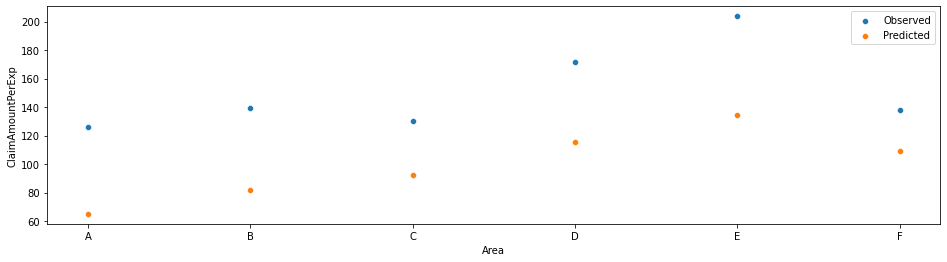

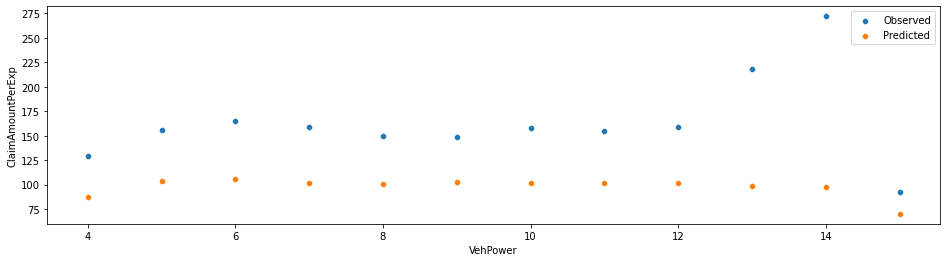

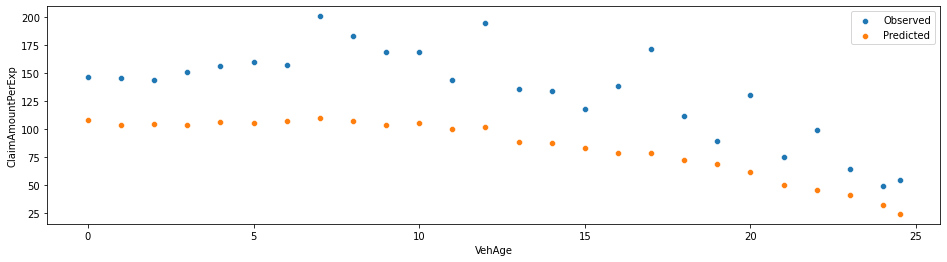

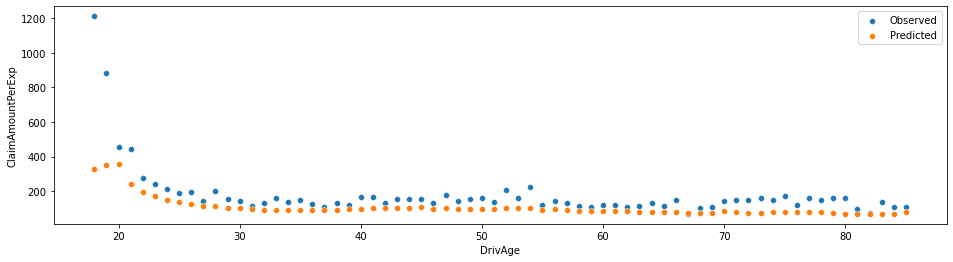

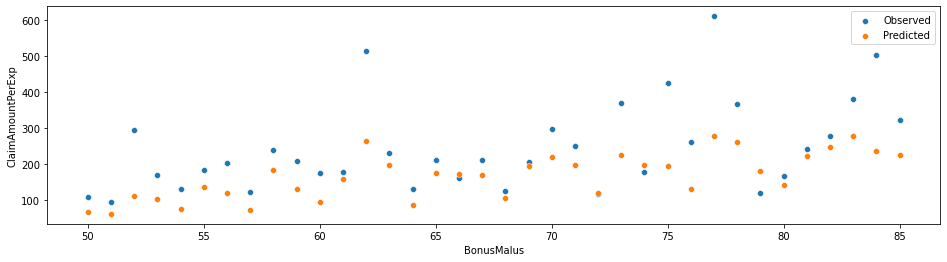

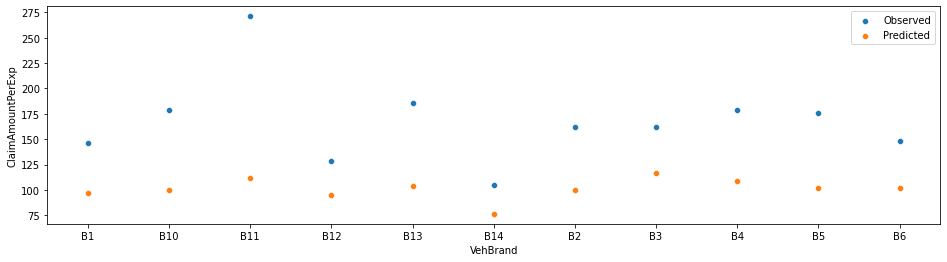

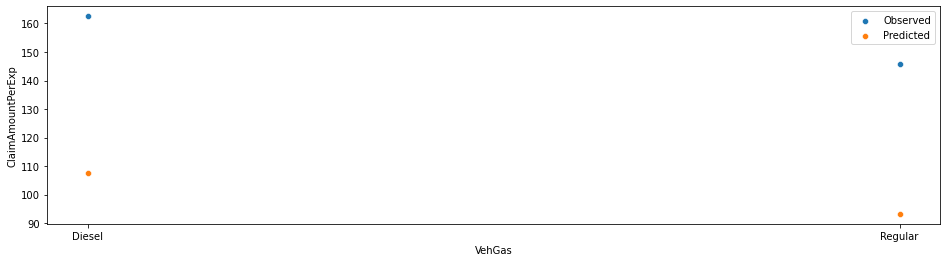

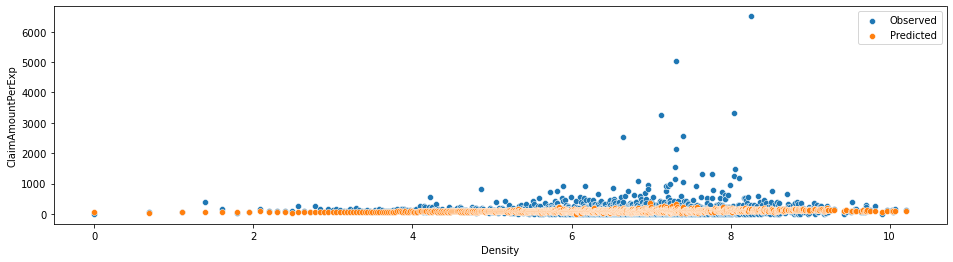

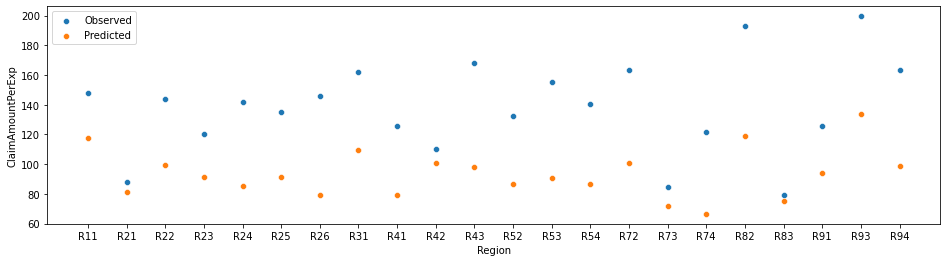

In [82]:
# Plotting observed and predicted values

for col in ['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    
    fig = plt.figure()
    fig.tight_layout()
    fig.set_figwidth(16)
    
    sns.scatterplot(x = df.groupby(col).mean().index, 
                    y = df.groupby(col).mean()['ClaimAmountPerExp'], 
                    label = 'Observed')
    sns.scatterplot(x = df.groupby(col).mean().index, 
                    y = df.groupby(col).mean()['ClaimAmountPerExpPreds'], 
                    label = 'Predicted')
   
    
    plt.legend()
    plt.show()

<br>
<div class="alert alert-warning">
Die Vorhersagen sind im Allgemeinen niedriger als die Beobachtungen, aber das Modell ist in der Lage, das Muster zu erfassen. Die Vorhersagen können durch Multiplikation mit einem Koeffizienten erhöht werden.
</div>

<br><br>

In [83]:
print("Test Data Evaluation\n","-"*20)
print(f"Observed     Mean:  {df['ClaimAmountPerExp'].mean():.4f} | Standard Dev: {df['ClaimAmountPerExp'].std():.4f}")
print(f"Predictions  Mean:  {df['ClaimAmountPerExpPreds'].mean():.4f} | Standard Dev: {df['ClaimAmountPerExpPreds'].std():.4f}")

print(f"\nRMSE: {np.sqrt(mean_squared_error(df['ClaimAmountPerExp'],df['ClaimAmountPerExpPreds'])):.4f}")
print(f"MAE:   {mean_absolute_error(df['ClaimAmountPerExp'],df['ClaimAmountPerExpPreds']):.4f}")

Test Data Evaluation
 --------------------
Observed     Mean:  153.9465 | Standard Dev: 2565.8897
Predictions  Mean:  100.1662 | Standard Dev: 85.0090

RMSE: 2563.3472
MAE:   241.7405


<br><br>

<a id='ch5-3-2'></a>

#### 5.3.2. Method II

The second method to predict Claim Amount/Exposure is to build another ML model using the inputs including Predicted Claim Frequency and Claim Severity.

In [84]:
# Copying the original dataframe
df_model = df.copy()
df_model = df_model.reset_index(drop = True)

In [85]:
df_model.head()

ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0        1      0.75    F      7.0     1.0     61.0        50.0      B12   
1        1      0.14    B     12.0     5.0     50.0        60.0      B12   
2        1      0.14    E      4.0     0.0     36.0        85.0      B12   
3        2      0.62    F     10.0     0.0     51.0        85.0      B12   
4        1      0.31    A      5.0     0.0     45.0        50.0      B12   

    VehGas    Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
0  Regular  10.203592    R11       303.00         303.00        1.333333   
1   Diesel   4.025352    R25      1981.84        1981.84        7.142857   
2  Regular   8.474703    R11      1456.55        1456.55        7.142857   
3  Regular  10.203592    R11     10834.00        5417.00        3.225806   
4  Regular   2.484907    R73      3986.67        3986.67        3.225806   

   ClaimAmountPerExp  ClaimFreqPreds  ClaimSeverityPreds  \
0         404.000000        0.060159         1716.935913   
1       14156.000000        0.091979          999.798889   
2       10403.928571        0.090665         1396.231201   
3       17474.193548        0.131912         2322.012939   
4       12860.225806        0.042136         1154.575439   

   ClaimAmountPerExpPreds  
0              103.289075  
1               91.960062  
2              126.589768  
3              306.302303  
4               48.649222

<br><br>

**Building Model**

* Wir werden die Merkmale der Versicherungsnehmer und frühere Prognosen als Inputs verwenden.

In [86]:
# Defining dependent variable
y = df_model['ClaimAmountPerExp']

# Creating train/test indices - 90%-10%
ss = ShuffleSplit(test_size=0.1, random_state=101)
train_index, test_index = next(ss.split(y))

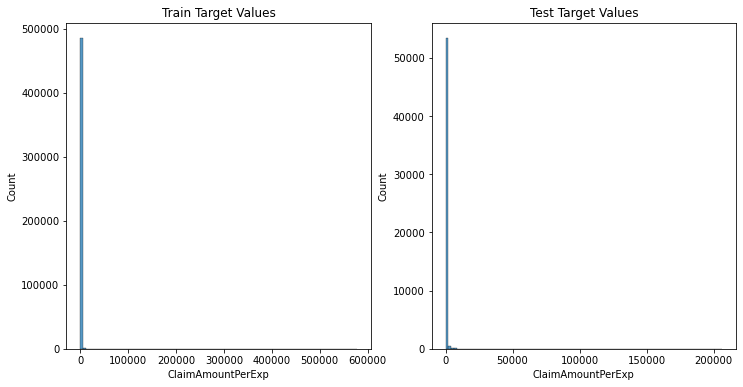

In [87]:
# Plotting train/test disributions of the target value

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.histplot(x = y.iloc[train_index], bins = 100, ax = ax[0])
ax[0].set_title('Train Target Values')
sns.histplot(x = y.iloc[test_index], bins = 100, ax = ax[1])
ax[1].set_title('Test Target Values')
plt.show()

In [88]:
# Defining independent variables
# We add also Predicted Claim Severity and Claim Severity as independent variable to increase prediction scores.
X = df_model[['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimFreqPreds', 'ClaimSeverityPreds']]

# One-hot Encoding categorical variables
X = pd.get_dummies(X)

# Splitting train/test
X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

# Scaling numerical variables
numeric_cols = ['VehAge', 'DrivAge', 'BonusMalus', 'Density','ClaimFreqPreds', 'ClaimSeverityPreds']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

In [90]:
# Fitting all regression models and record the scores
regression_algorithms = [ElasticNet(), 
                         TweedieRegressor(power=1), TweedieRegressor(power=1.5), TweedieRegressor(power=1.9),

                         GradientBoostingRegressor(), HistGradientBoostingRegressor('poisson'),
                         
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.1), 
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.5),
                         XGBRegressor(objective="reg:tweedie", tweedie_variance_power = 1.7),
                         
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1), 
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.5), 
                         LGBMRegressor(objective= "tweedie", tweedie_variance_power = 1.9), 
                         
                         CatBoostRegressor(verbose=0), 
                         CatBoostRegressor(loss_function= 'Tweedie:variance_power=1.5', verbose=0),
                         
                         RandomForestRegressor(criterion= 'poisson')]


result_table = pd.DataFrame(columns = ['model','MSLE', 'RMSE', 'MAE', 'R2'])
for model in regression_algorithms:
    create_reg_model(model, sample_weight= df_model['Exposure'])

-------------------------------------------------- 
 ElasticNet()
-------------------------------------------------- 
 TweedieRegressor(power=1)
-------------------------------------------------- 
 TweedieRegressor(power=1.5)
-------------------------------------------------- 
 TweedieRegressor(power=1.9)
-------------------------------------------------- 
 GradientBoostingRegressor()
-------------------------------------------------- 
 HistGradientBoostingRegressor(loss='poisson')
-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-------------------------------------------------- 
 XGBRegressor(base_score=None, booster=None, callbacks=None,

-------------------------------------------------- 
 LGBMRegressor(objective='tweedie', tweedie_variance_power=1)
-------------------------------------------------- 
 LGBM

<br><br>

**Model Evaluation**

<AxesSubplot:ylabel='model'>

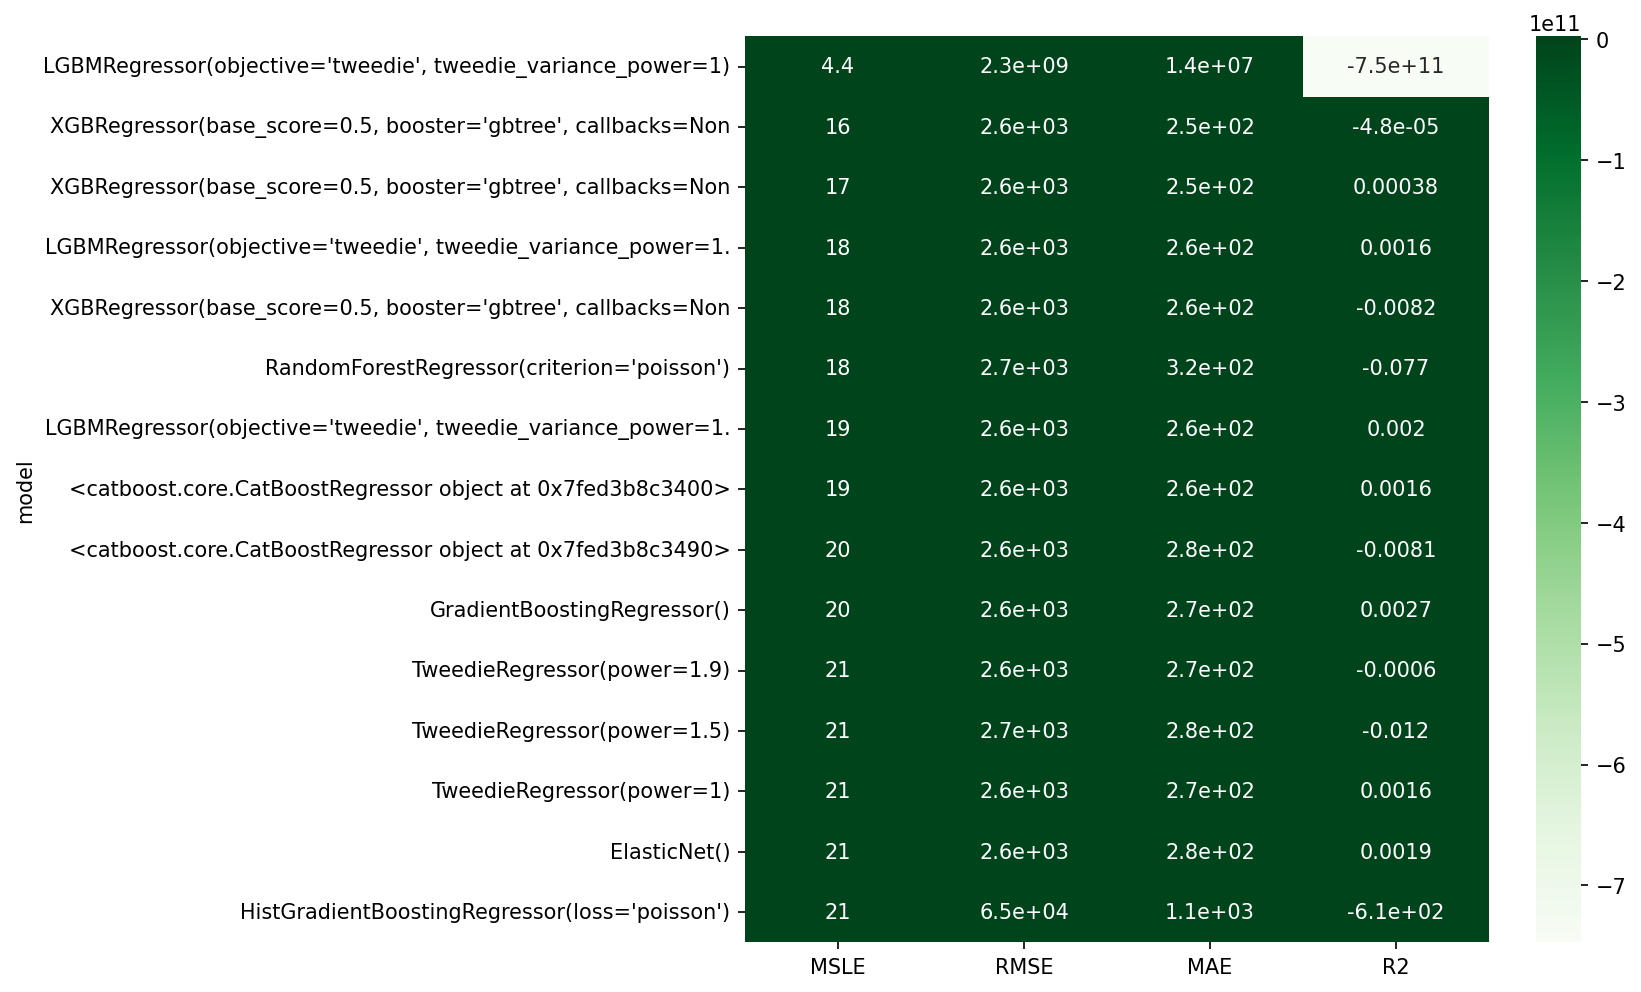

In [91]:
# Plotting the scores

plt.figure(figsize = (8,8), dpi = 150)
sns.heatmap(result_table.set_index('model').sort_values(by = 'MSLE', ascending = True), annot = True, cmap = 'Greens')

<br><br>

<br>
<div class="alert alert-warning">
XGBRegressor liefert die besten MLSE bei der Vorhersage von ClaimAmount/Exposure. Auf der anderen Seite hat GradientBoostingRegressor einen weitaus höheren R2-Wert. Lassen Sie uns beide untersuchen.
</div>

<br><br>

**Model Selection and Hyperparameter Tuning**

In [92]:
# Defining the selected model and getting parameters
model = XGBRegressor()
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

<div class="alert alert-danger">
  Es gibt viele Parameter, die wir einstellen können, aber das kostet zu viel Zeit. Wir wählen einige für einen Versuch aus.
</div>

In [93]:
# Defining tuning parameters

param_grid = {
    'objective': ["reg:tweedie"],
    'tweedie_variance_power': np.arange(1,2,0.1)
}

# Defining CV model

tuned_model = GridSearchCV(XGBRegressor(), param_grid, scoring = 'neg_mean_squared_log_error', cv = 3)



In [94]:
# Fitting the CV model

tuned_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

<br>

In [95]:
# Getting best parameters

tuned_model.best_params_

{'objective': 'reg:tweedie', 'tweedie_variance_power': 1.8000000000000007}

<br><br>

**Results**

<br><br>

**XGBBoostRegressor**

In [96]:
# Building the final model
claim_amount_model = XGBRegressor(objective= "reg:tweedie", tweedie_variance_power = 1.8)
claim_amount_model.fit(X_train,y_train)
y_pred = claim_amount_model.predict(X_test)

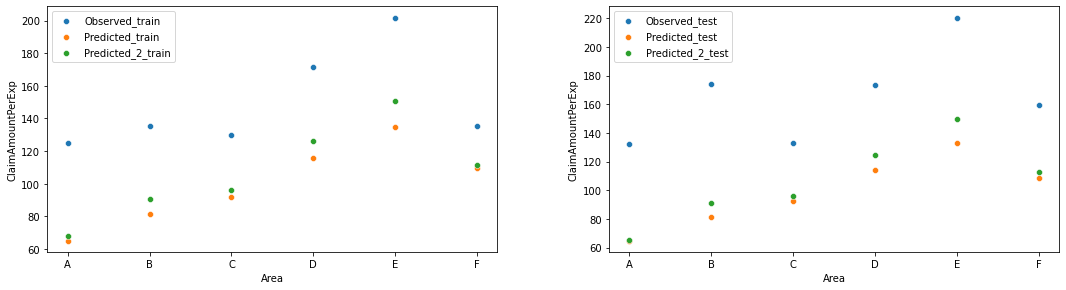

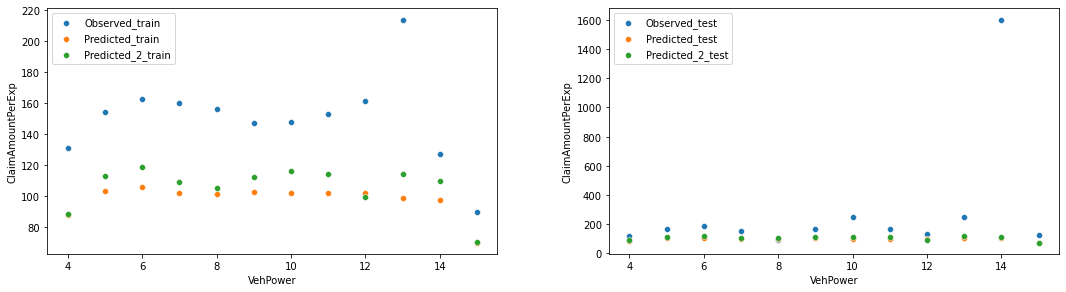

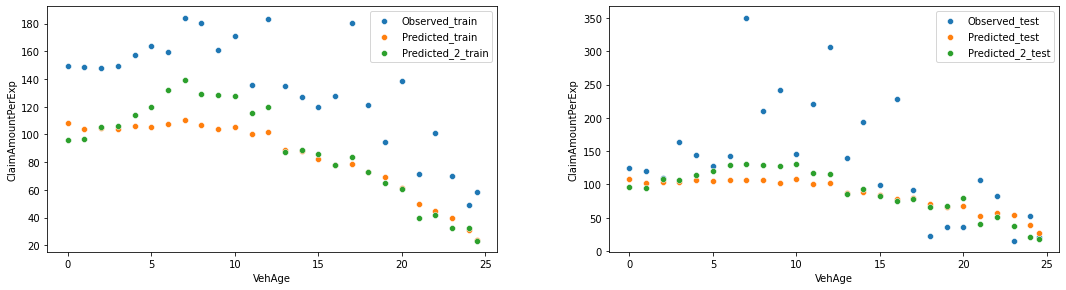

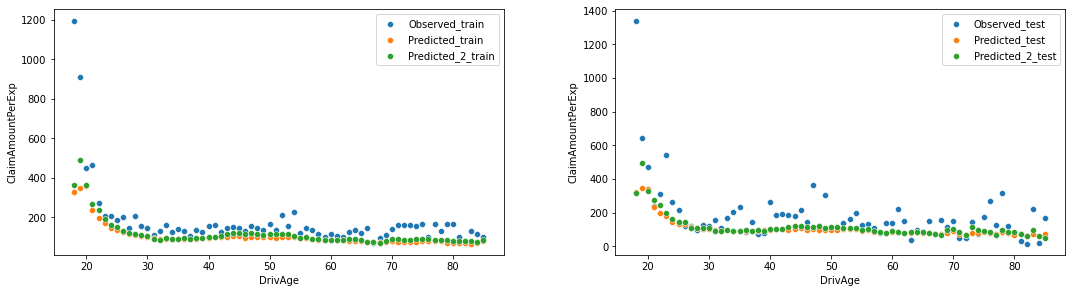

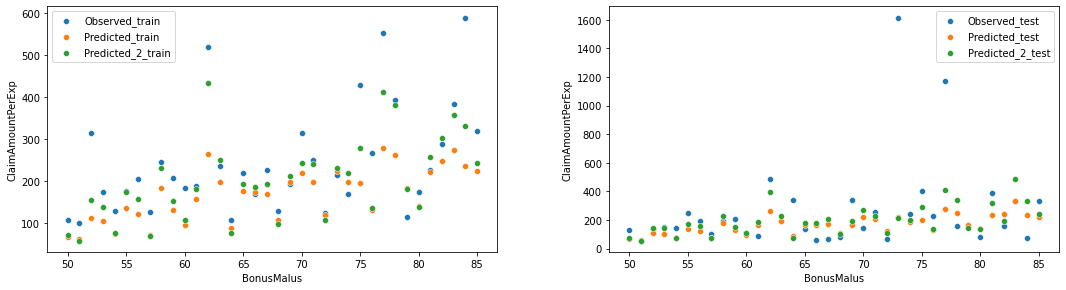

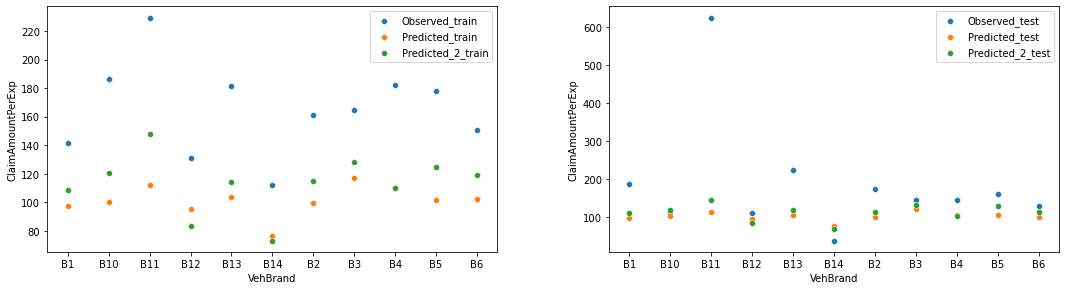

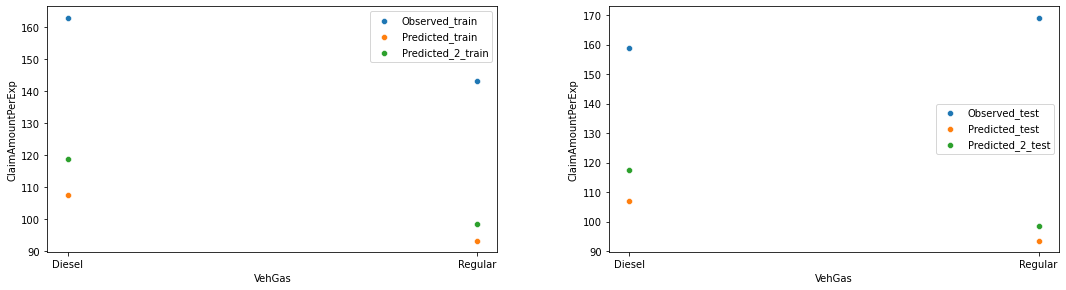

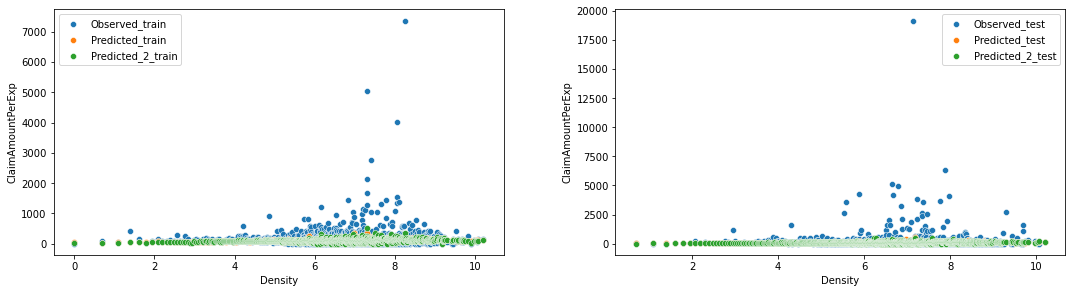

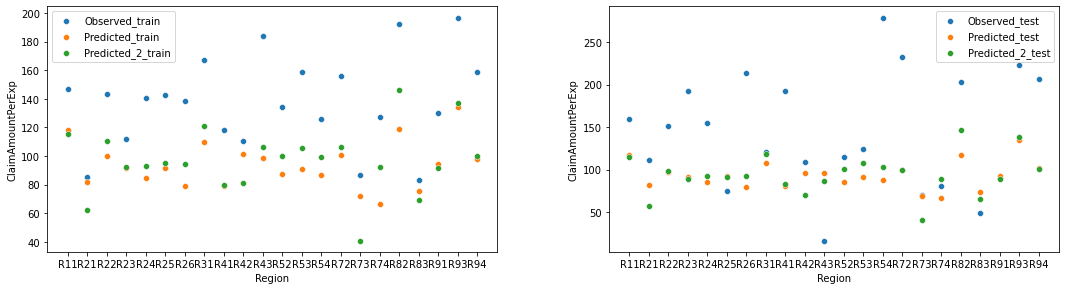

In [97]:
# Saving the prediction values for plotting
df_model['ClaimAmountPerExpPreds2'] = claim_amount_model.predict(X)

# Plotting observed and predicted values for train/test

for col in ['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    fig.set_figwidth(16)
    
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimAmountPerExp'], 
                    ax = ax[0], label = 'Observed_train')
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimAmountPerExpPreds'], 
                    ax = ax[0], label = 'Predicted_train')
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimAmountPerExpPreds2'], 
                    ax = ax[0], label = 'Predicted_2_train')
   
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimAmountPerExp'], 
                    ax = ax[1], label = 'Observed_test')
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimAmountPerExpPreds'], 
                    ax = ax[1], label = 'Predicted_test')
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimAmountPerExpPreds2'], 
                    ax = ax[1], label = 'Predicted_2_test')
    
    plt.legend()
    plt.show()

<br>
<div class="alert alert-warning">  
Die neuen Vorhersagen liegen etwas näher an den beobachteten Werten, aber das ist nicht gut genug. Gradientboosting kann eine bessere Anpassung liefern, da es einen höheren R2-Wert aufweist.
</div>

<br><br>

**GradientBoostingRegressor**

In [98]:
# Building the final model
claim_amount_model = GradientBoostingRegressor()
claim_amount_model.fit(X_train,y_train)
y_pred = claim_amount_model.predict(X_test)

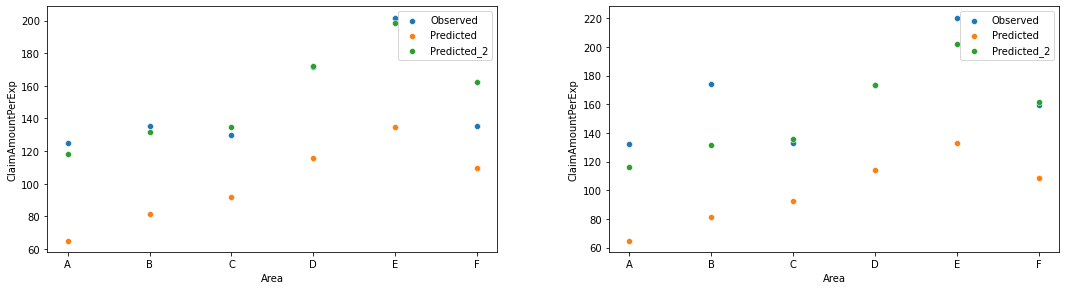

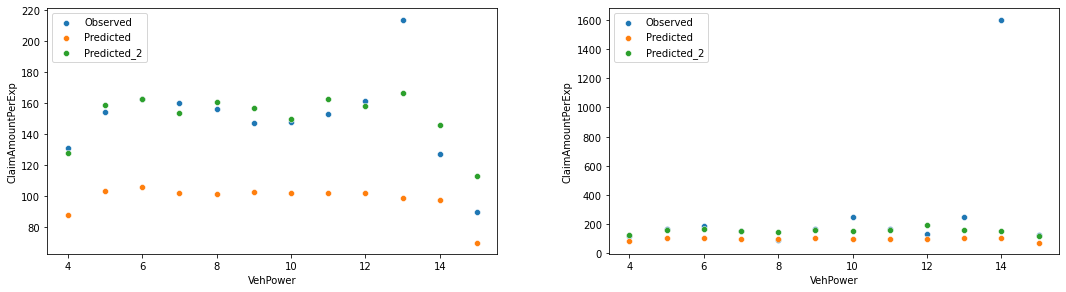

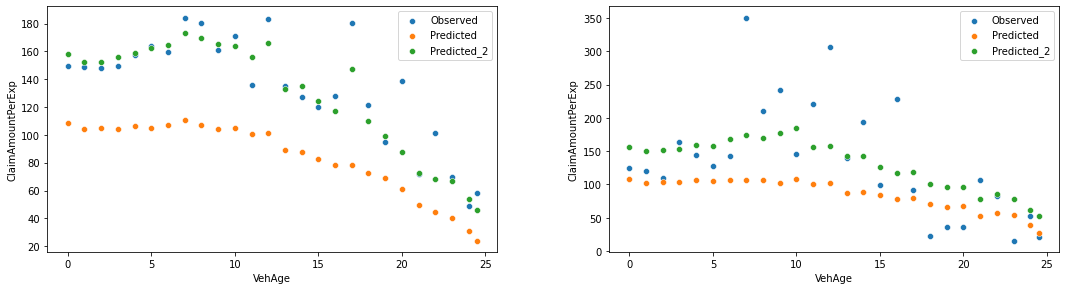

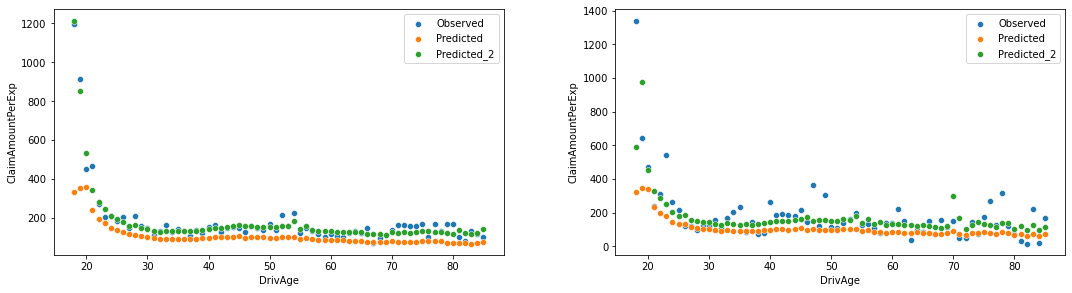

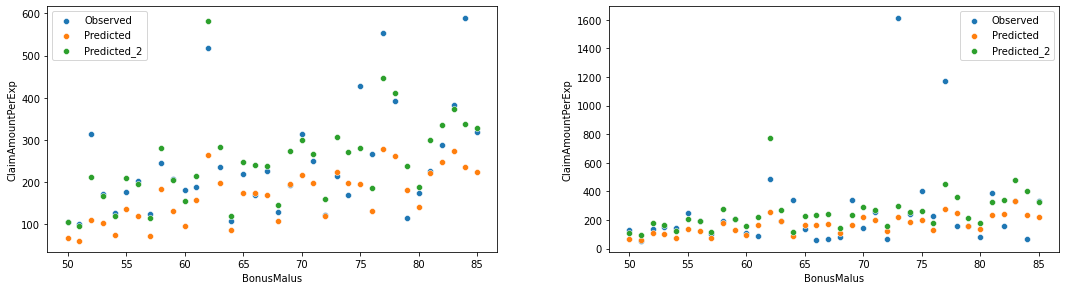

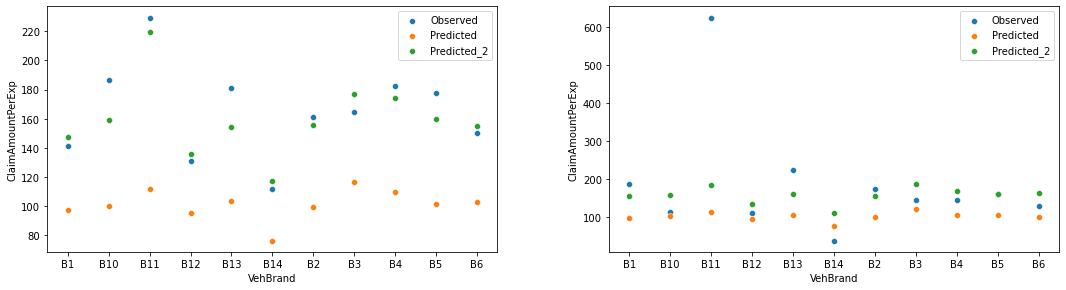

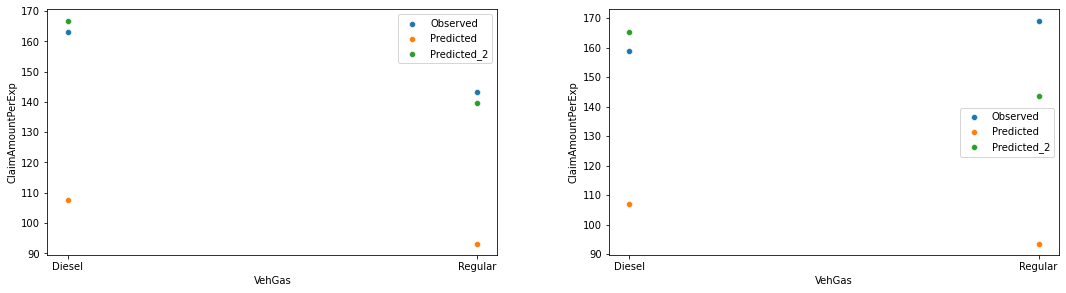

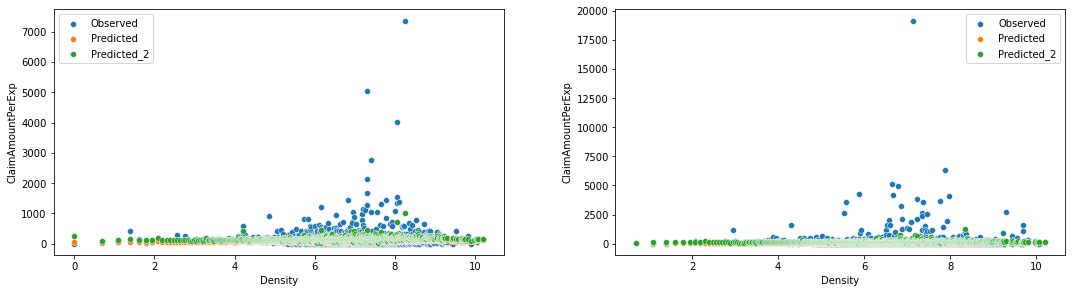

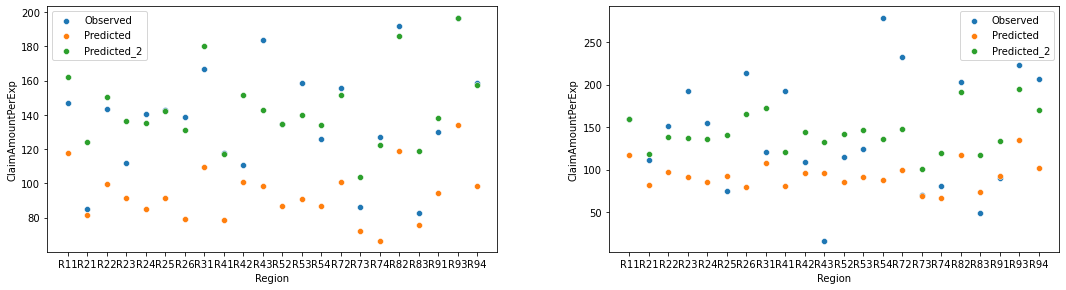

In [99]:
# Saving the prediction values for plotting
df_model['ClaimAmountPerExpPreds2'] = claim_amount_model.predict(X)

# Plotting observed and predicted values for train/test

for col in ['Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    fig.set_figwidth(16)
    
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimAmountPerExp'], 
                    ax = ax[0], label = 'Observed')
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimAmountPerExpPreds'], 
                    ax = ax[0], label = 'Predicted')
    sns.scatterplot(x = df_model.iloc[train_index].groupby(col).mean().index, 
                    y = df_model.iloc[train_index].groupby(col).mean()['ClaimAmountPerExpPreds2'], 
                    ax = ax[0], label = 'Predicted_2')
   
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimAmountPerExp'], 
                    ax = ax[1], label = 'Observed')
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimAmountPerExpPreds'], 
                    ax = ax[1], label = 'Predicted')
    sns.scatterplot(x = df_model.iloc[test_index].groupby(col).mean().index, 
                    y = df_model.iloc[test_index].groupby(col).mean()['ClaimAmountPerExpPreds2'], 
                    ax = ax[1], label = 'Predicted_2')
    
    plt.legend()
    plt.show()

<br>
<div class="alert alert-warning">  
Der XGBRegressor hat die besten Werte bei MLSE und RMSE, aber GradientBoosting hat den besten R2-Wert. Die Abbildung zeigt, dass die Ergebnisse des GradientBoostingRegressors viel besser passen als die des XGBRegressors. Insgesamt kann die mittlere ClaimAmount/Exposure mit ML-Modellen sehr gut vorhergesagt werden.
</div>

<br><br>

In [100]:
print("Test Data Evaluation\n","-"*20)
print(f"Observed       Mean:  {df_model['ClaimAmountPerExp'].mean():.4f} | Standard Dev: {df_model['ClaimAmountPerExp'].std():.4f}")
print(f"Predictions    Mean:  {df_model['ClaimAmountPerExpPreds'].mean():.4f} | Standard Dev: {df_model['ClaimAmountPerExpPreds'].std():.4f}")
print(f"Predictions_2  Mean:  {df_model['ClaimAmountPerExpPreds2'].mean():.4f} | Standard Dev: {df_model['ClaimAmountPerExpPreds2'].std():.4f}")

Test Data Evaluation
 --------------------
Observed       Mean:  153.9465 | Standard Dev: 2565.8897
Predictions    Mean:  100.1662 | Standard Dev: 85.0090
Predictions_2  Mean:  152.9267 | Standard Dev: 504.6157


<br><br>

**Saving Results**

In [101]:
# Saving final predictions to the original dataframe
df['ClaimAmountPerExpPreds'] = claim_amount_model.predict(X)

In [102]:
df.head()

ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                          
139          1      0.75    F      7.0     1.0     61.0        50.0      B12   
190          1      0.14    B     12.0     5.0     50.0        60.0      B12   
414          1      0.14    E      4.0     0.0     36.0        85.0      B12   
424          2      0.62    F     10.0     0.0     51.0        85.0      B12   
463          1      0.31    A      5.0     0.0     45.0        50.0      B12   

        VehGas    Density Region  ClaimAmount  ClaimSeverity  ClaimFrequency  \
IDpol                                                                          
139    Regular  10.203592    R11       303.00         303.00        1.333333   
190     Diesel   4.025352    R25      1981.84        1981.84        7.142857   
414    Regular   8.474703    R11      1456.55        1456.55        7.142857   
424    Regular  10.203592    R11     10834.00        5417.00        3.225806   
463    Regular   2.484907    R73      3986.67        3986.67        3.225806   

       ClaimAmountPerExp  ClaimFreqPreds  ClaimSeverityPreds  \
IDpol                                                          
139           404.000000        0.060159         1716.935913   
190         14156.000000        0.091979          999.798889   
414         10403.928571        0.090665         1396.231201   
424         17474.193548        0.131912         2322.012939   
463         12860.225806        0.042136         1154.575439   

       ClaimAmountPerExpPreds  
IDpol                          
139                110.050131  
190                191.978513  
414                159.670889  
424                425.758694  
463                123.154923

<br><br>

**Feature Importance**

In [103]:
# Creating a dataframe for feature coefficients
imp_feats = pd.DataFrame(data = claim_amount_model.feature_importances_,
                         index = X.columns,columns = ['Feature Importance']).sort_values("Feature Importance")

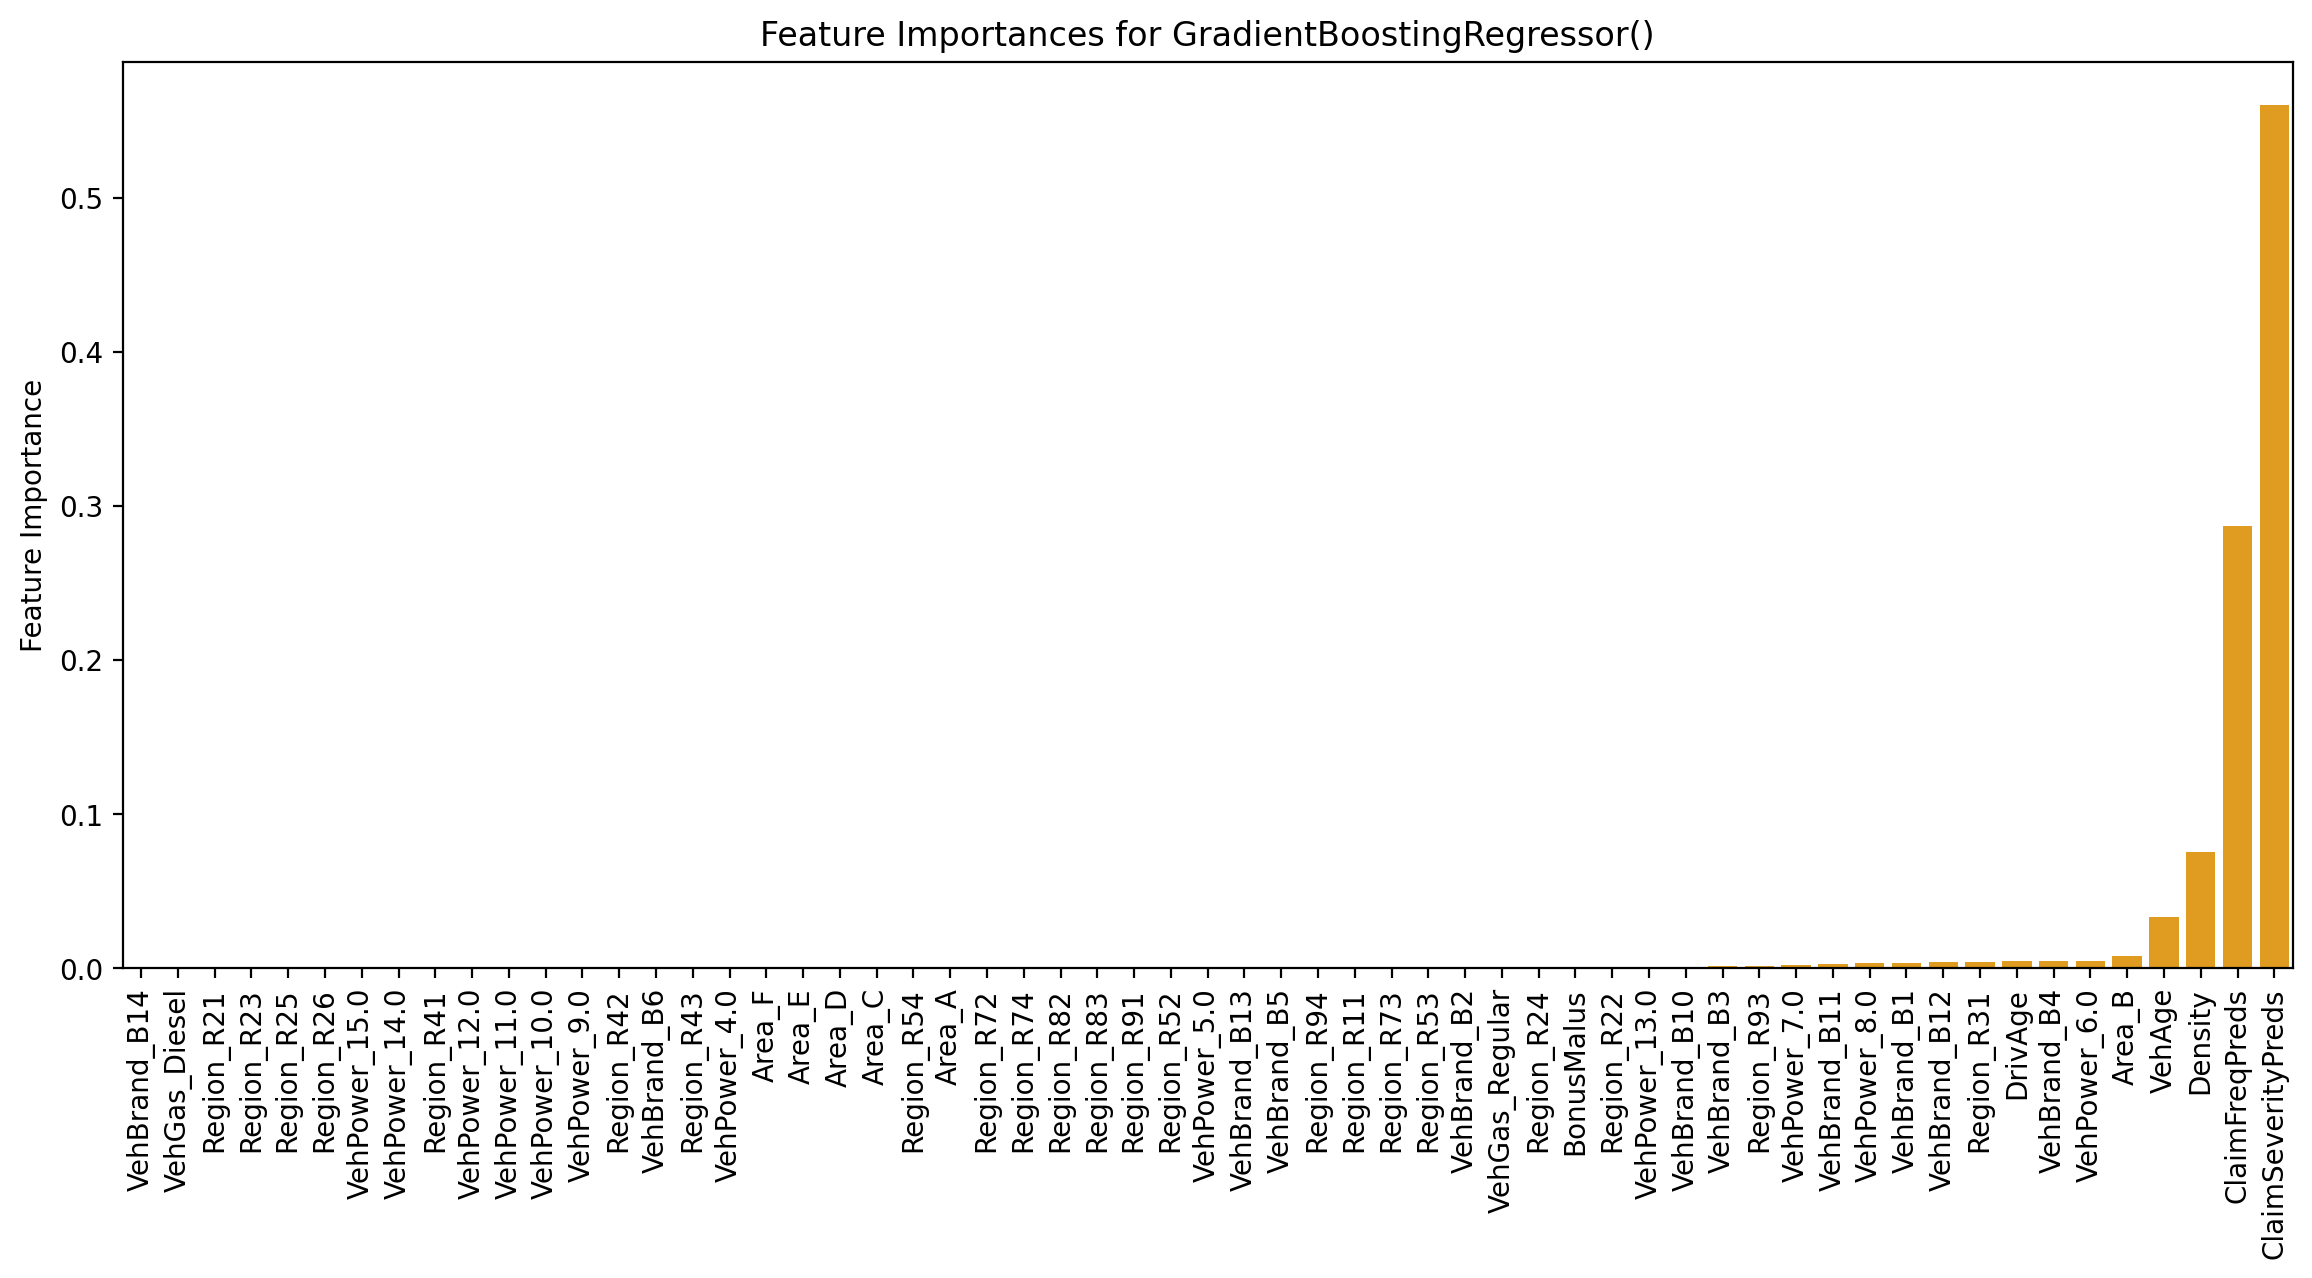

In [104]:
# Plotting feature coefficients
plt.figure(figsize = (14,6), dpi = 200)
sns.barplot(data = imp_feats,
            x = imp_feats.index,
            y = 'Feature Importance', color = 'orange')
plt.xticks(rotation = 90)
plt.title(f"Feature Importances for {claim_amount_model}");

<div class="alert alert-info">
  <strong>Bewertung der Bedeutung von Merkmalen</strong>
</div>

* Wie erwartet sind die Vorhersagen von ClaimSeverity und ClaimFrequency die wichtigsten Merkmale. 
* Andere Merkmale wie **Density**, **DrivAge** tragen zur Vorhersage von ClaimAmount/Exposure bei, so dass das Modell eine bessere Vorhersage liefert als die einfache Multiplikation von ClaimSeverity und ClaimFrequency.

<br><br>

<br>[Return to the Outline](#outline) <br>

<a id='ch6'></a>

## 6. Conclusion

Die Vorhersage von ClaimAmount ist eine wichtige Aufgabe für Versicherungsunternehmen, um eine faire Prämiengestaltung zu erreichen. In dieser Arbeit haben wir ML-Modelle zur Vorhersage von ClaimAmount entwickelt. Um bessere Vorhersagen zu treffen, haben wir auch ML-Modelle zur Vorhersage der ClaimFrequency und der ClaimSeverity erstellt und diese Vorhersagen verwendet, um faire Schadenbeträge zu finden. 

Wir begannen mit der Bereinigung der Datensätze. Dann haben wir eine explorative Datenanalyse und ein Feature Engineering durchgeführt, um bessere ML-Modelle zu erstellen. 

Zunächst haben wir ML-Modelle zur **Vorhersage der ClaimFrequency** erstellt. Dieses Merkmal hat eine Poisson-Verteilung. Wir haben also **GLM Regressors** zb. TweedieRegressor, PoissonRegressor und **baumbasierte Algorithmen** ausprobiert. Die R2-Werte der Modelle waren schlecht. Wir haben uns für den **LGBMRegressor** entschieden, weil er den niedrigsten MSLE ergab. Wir haben LGBM so modifiziert, dass es mit der Poisson-Verteilung umgehen kann, und die Tuning-Ergebnisse zeigen, dass eine **Tweedie-Potenz von 1,7** die beste Fehlerbewertung ergibt.  Wir haben das Modell abgestimmt und die Vorhersagen gespeichert.

Zweitens wiederholten wir das Verfahren für die **ClaimSeverity**. Sie hat eine Gamma-Verteilung, also haben wir **GLM Regressors** zb. TweedieRegressor, GammaRegressor und baumbasierte Algorithmen ausprobiert. Der **XGBRegressor** liefert die besten Ergebnisse. Wir haben die XGB so modifiziert, dass sie mit der Tweedie-Verteilung umgehen kann, und eine **Tweedie-Leistung von 1,8** ergab das beste Ergebnis.

Schließlich haben wir zwei Methoden zur **Vorhersage von ClaimAmount/Exposure** ausprobiert. Die erste Methode ist die einfache **Multiplikation von ClaimFrequency und ClaimSeverity**. Die zweite Methode besteht darin, ein weiteres ML-Modell zu erstellen. Die Erstellung eines ML-Modells verbesserte die Ergebnisse erheblich. Der **XGBRegressor** ergab den besten RMSE-Wert, der **GradientBoostingRegressor** jedoch den besten R2-Wert. Wenn die Daten visualisiert werden, zeigt sich, dass GradientBoosting die genauesten mittleren Vorhersagen liefert.

**Drivage**, **Density**, **VehAge** und **BonusMalus** waren das wichtigste Merkmalen zur Vorhersage der ClaimFrequency. 

**Regionen** und **Fahrzeugeigenschaften** waren die wichtigsten Merkmale für die Vorhersage der ClaimSeverity. 

Die **vorhergesagte ClaimFrequency und ClaimSeverity** haben den größten Koeffizienten für die Vorhersage der **ClaimAmount/Exposure**. Andere Merkmale wie **Density**, **DrivAge** tragen zur Vorhersage von ClaimAmount/Exposure bei. 

Diese Studie kann erweitert werden;
* durch die Anwendung anderer ML-Algorithmen sowie Deep-Learning-Methoden.
* Darüber hinaus sollte eine umfassende Abstimmung der Modelle vorgenommen werden, um noch bessere Ergebnisse zu erzielen. Darüber hinaus können für die Modellierung verschiedene sample_weights gewählt werden
* Schließlich sollten regelmäßige Erfahrungsanalysen durchgeführt werden, um die Vorhersagen zu bewerten und bessere und konsistentere Modelle zu entwickeln.


<br><br>

> **Check Tableau Dashboard created using this data:** https://github.com/DrFarukAydin/data-science-portfolio

> **Check my other works in my Github Page:** https://github.com/DrFarukAydin/data-science-portfolio

<br>[Return to the Outline](#outline) <br>